## Bystrov Pavel masters student/ University of Malta (Department of AI)


* adaptation of modified Jeff Hinton's contrastive WAKE-SLEEP Algorithm used in Stacked RBMs/DBMs for linear classifiers, logistic regression, simple convolutional neural networks and RNNs

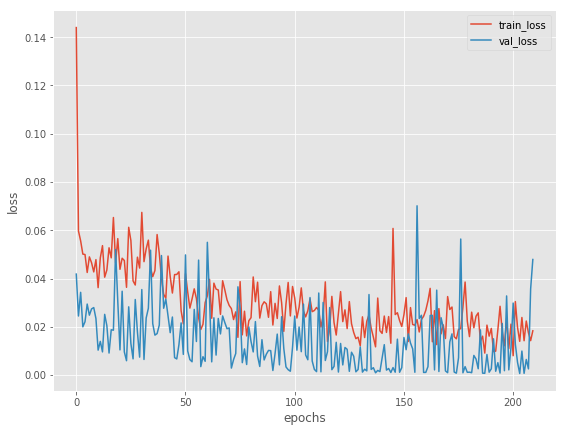

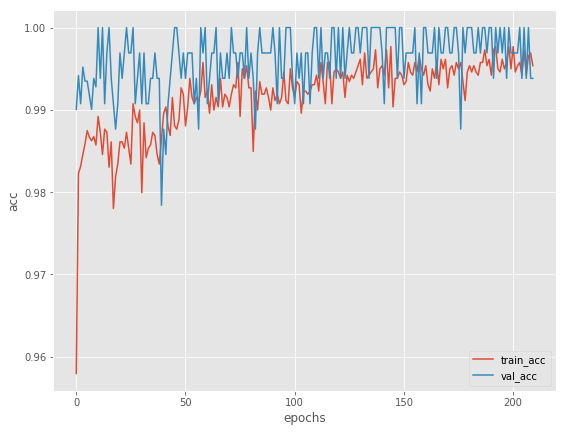

class predictions tensor([1, 3, 0, 1], device='cuda:0')
probability curve wrt angle tensor([[[6.1152e-08, 2.1241e-10, 3.0011e-08, 2.1792e-12, 1.2377e-12,
          7.3741e-14, 5.1117e-09, 3.4640e-06, 7.0913e-10],
         [3.7187e-03, 7.6546e-01, 9.9998e-01, 1.0000e+00, 5.8190e-03,
          1.0000e+00, 9.9962e-01, 9.9623e-01, 9.9994e-01],
         [8.3023e-01, 2.1884e-05, 1.8178e-12, 4.8660e-09, 9.9418e-01,
          7.0266e-08, 4.5847e-06, 8.9636e-05, 7.1593e-09],
         [3.2083e-12, 2.3452e-01, 1.0935e-05, 1.7387e-16, 4.0366e-10,
          4.7026e-06, 1.2723e-08, 3.6554e-03, 5.7123e-05],
         [1.6605e-01, 2.4840e-12, 1.2721e-05, 8.5523e-10, 1.6774e-08,
          3.7103e-11, 3.7788e-04, 2.0893e-05, 1.8135e-07]],

        [[4.2297e-06, 2.5645e-04, 4.0866e-10, 6.4070e-14, 1.2288e-04,
          1.0192e-07, 5.6470e-12, 1.0311e-08, 1.7723e-08],
         [1.0000e+00, 3.3070e-09, 7.0332e-09, 3.2991e-05, 2.1283e-02,
          7.8558e-06, 3.7176e-12, 1.9559e-08, 9.4701e-07],
         [1

In [20]:
import pickle
from skimage import io
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from matplotlib import colors, pyplot as plt
import  torchvision.models
##################################################################################################
# training and testing results of CNN with Li-group invariants
####################################################################################################
# It shows that both classifiers trained to 98% accuracy
# but 9 probabilities after 1st Softmax layer showed form of linear shape
# Only in 4th case they showed some kind of dependency that looks like bell-shaped curve after few steps of training
# prediction for class 1:
#[3.4838e-12, 1.3894e-02, 9.9187e-01, 1.0000e+00, 6.7122e-02, 9.8690e-01, 9.9998e-01, 9.9995e-01, 9.9977e-01]
####################################################################################################
# I run this function after step 19)
#display_results()

In [3]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
#from fastai import *
#from fastai.vision import *
#from fastai.basic_train import Learner
#from fastai import LRFinder
from torchvision.models import resnet18
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
from torchvision.models import mobilenet_v2
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.nn import ReLU, Linear, Sigmoid, Tanh, Flatten, LogSigmoid, LogSoftmax, Softmax, BatchNorm2d, BatchNorm1d
from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Sequential, Conv2d, Conv1d, MaxPool2d, MaxPool1d
from sklearn.model_selection import train_test_split
# в sklearn не все гладко, чтобы в colab удобно выводить картинки мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

matplotlib.style.use('ggplot')
%matplotlib inline

# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
WAKE_PHASE = 0

def freeze(cnn):
    for param in cnn.parameters():
        param.requires_grad = False


def unfreeze(cnn):
    for param in cnn.parameters():
        param.requires_grad = True


class WsleepMobileNet(nn.Module):
    def __init__(self, mobinet):
        super().__init__()
        self.enable_wakesleep = False
        self.total_phases = 0
        self.current_phase = WAKE_PHASE
        self.cnn = mobinet
    
    
    def freeze(self):
        for param in self.cnn.parameters():
            param.requires_grad = False
    
    
    def unfreeze(self):
        for param in self.cnn.parameters():
            param.requires_grad = True

    
    def next_phase(self):
        #TO BE IMPLEMENTED: RETURN True on every sleep phase
        #or False in wake phase
        return False

    
    def wake_up(self):
        #TO BE FINALIZED
        self.current_phase = WAKE_PHASE
        return True
    
    
    def get_phase(self):
        return self.current_phase 

    
    def forward(self, x):
        logits = self.cnn(x)
        return logits

    
def get_mnet(cnn):
    out = WsleepMobileNet(cnn)
    return out.to(DEVICE)


class WakeSleepNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enable_wakesleep = False
        self.total_phases = 0
        self.current_phase = WAKE_PHASE
    
    
    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    
    
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True

    
    def next_phase(self):
        #TO BE IMPLEMENTED: RETURN True on every sleep phase
        #or False in wake phase
        return False

    
    def wake_up(self):
        #TO BE FINALIZED
        self.current_phase = WAKE_PHASE
        return True
    
    
    def get_phase(self):
        return self.current_phase 

        
    
class Logreg(WakeSleepNN):
    def __init__(self, n_outputs = 2):
        super().__init__()
        self.out2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(RESCALE_SIZE*RESCALE_SIZE*3, 1, bias=True))
        
    def forward(self, x):
        logits = self.out2(x)
        return logits


class LogregAlike(WakeSleepNN):
    def __init__(self, n_outputs):
        super().__init__()
        self.out2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(RESCALE_SIZE*RESCALE_SIZE*3, n_outputs, bias=True))
        
    def forward(self, x):
        logits = self.out2(x)
        return logits


class LogregAlikeSigm3L(WakeSleepNN):
    def __init__(self, n_outputs):
        super().__init__()
        self.out2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(RESCALE_SIZE*RESCALE_SIZE*3, n_outputs+1, bias=True),
            nn.Sigmoid(),
            nn.Linear(n_outputs+1, n_outputs+1, bias=True),
            nn.Sigmoid(),
            nn.Linear(n_outputs+1, n_outputs, bias=True)
        )
        
    def forward(self, x):
        logits = self.out2(x)
        return logits

    
class LogregAlikeRelu3L(WakeSleepNN):
    def __init__(self, n_outputs):
        super().__init__()
        self.out2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(RESCALE_SIZE*RESCALE_SIZE*3, n_outputs+1, bias=True),
            nn.Softmax(1),
            BatchNorm1d(n_outputs+1),
            nn.Linear(n_outputs+1, n_outputs+1, bias=True),
            ReLU(),
            BatchNorm1d(n_outputs+1),
            nn.Linear(n_outputs+1, n_outputs, bias=True)
        )
        
    def forward(self, x):
        logits = self.out2(x)
        return logits

    
class LogregAlikeTanh3L(WakeSleepNN):
    def __init__(self, n_outputs):
        super().__init__()
        self.out2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(RESCALE_SIZE*RESCALE_SIZE*3, 7, bias=True),
            torch.nn.Softmax(1),
            nn.Linear(n_outputs+1, n_outputs+1, bias=True),
            Tanh(),
            nn.Linear(n_outputs+1, n_outputs, bias=True)
        )
        
    def forward(self, x):
        logits = self.out2(x)
        return logits
    
class ConvNet8L(WakeSleepNN):
    def __init__(self, n_classes):
        super().__init__()
        self.out1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #111x111
            BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #54x54
            nn.Flatten(),
            BatchNorm1d(46656),
            nn.Linear(46656, 512),
            nn.Tanh(),
            BatchNorm1d(512),
            nn.Linear(512, n_classes)
        )
        
    def forward(self, x):
        logits = self.out1(x)
        return logits
    
class ConvNet6L(WakeSleepNN):
    def __init__(self, n_classes):
        super().__init__()
        self.out1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #111x111
            BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #54x54
            nn.Flatten(),
            BatchNorm1d(46656),
            nn.Linear(46656, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes)
        )
        
    def forward(self, x):
        logits = self.out1(x)
        return logits

    
class ComplexLogreg(WakeSleepNN):
    def __init__(self, n_classes, nn1, nn2):
        super().__init__()
        self.enable_wakesleep = True
        self.total_phases = 3
        self.cnn1 = nn1
        self.cnn1.freeze()
        self.cnn2 = nn2
        self.cnn2.freeze()
        self.out1 = nn.Sequential(
            nn.Linear(n_classes*2, n_classes+1),
            nn.Tanh(),
            nn.Linear(n_classes+1, n_classes)
        )
        
    def forward(self, x):
        x1 = nn.Softmax(1)(self.cnn1(x))
        x2 = nn.Softmax(1)(self.cnn2(x))
        logits = self.out1(torch.cat((x1, x2), dim=1))
        return logits
    
    def next_phase(self):
        """RETURN True on every sleep phase or False in wake phase""" 
        self.current_phase += 1
        if self.current_phase >= self.total_phases:
            self.wake_up()
            return False
        if self.current_phase == (WAKE_PHASE+1) : # NN 1 trained
            self.cnn1.unfreeze()
            return True
        self.cnn1.freeze() # NN 2 trained
        self.cnn2.unfreeze()
        return True
        
    
    def wake_up(self):
        self.cnn1.freeze()
        self.cnn2.freeze()
        self.current_phase = WAKE_PHASE
        return True


def cmp_logreg3(nn1, nn2, n_outputs = 5):
    cnn = ComplexLogreg(n_outputs, nn1, nn2)
    return cnn.to(DEVICE)

def convnet8l(n_outputs = 5):
    cnn = ConvNet8L(n_outputs)
    return cnn.to(DEVICE)

def convnet6l(n_outputs = 5):
    cnn = ConvNet6L(n_outputs)
    return cnn.to(DEVICE)

def logreg(n_outputs = 5):
    result = LogregAlike(n_outputs)
    return result
    
####
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

#делаем независимую проверку точности на тестовом датасете
def get_avg_la(my_model, test_ds):
    loss, acc, f1 = my_model.evaluate(test_ds)
    return loss, acc, f1

print(DEVICE)

cuda


In [5]:
def save_encoder(file_name, encoder):
    with open(file_name, 'wb') as le_dump_file:
        pickle.dump(encoder, le_dump_file)
    return

def get_label_encoder(labels):
    x = torch.from_numpy(array(range(len(labels))))
    y = torch.zeros(len(labels), len(labels))
    y[range(y.shape[0]), x.view(1, x.shape[0])] = 1
    return {labels[i]:y[i] for i in range(0, len(labels))}


def get_reversed_encoder(labels):
    le = get_label_encoder(labels)
    return {x[1]:x[0] for x in le.items()}

class BaseDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder_file='label_encoder.pkl'):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            save_encoder(encoder_file, self.label_encoder)
    
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(file)
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x , dtype='float32') / 255.
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        w,h = image.size
        img0 = image
        if (w > h):
            img0 = transforms.Pad((0,(w-h)//2,0,w-h-((w-h)//2)))(image)
        elif (w < h):
            img0 = transforms.Pad(((h-w)//2,0,h-w-((h-w)//2), 0))(image)
        w,h = img0.size
        if(w == RESCALE_SIZE and h == RESCALE_SIZE):
            return img0
        return transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(img0)

    
    def __check_encoder_dims__(self, dims):
        nclasses = len(set(self.labels))
        if(dims != nclasses):
            print("LESS DIMS ", nclasses)
        return nclasses
            

class TransformedDataset(BaseDataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и делает рандом кроп с аугментацией
    """
    def __init__(self, files, mode, encoder_file='label_encoder.pkl'):
        super().__init__(files, mode, encoder_file)
        return


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        image = Image.open(file)
        #image.load()
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        w,h = x.size
        if (w > h):
            x = transforms.Pad((0,(w-h)//2,0,w-h-((w-h)//2)))(x)
        elif (w < h):
            x = transforms.Pad(((h-w)//2,0,h-w-((h-w)//2), 0))(x)
        
        hh = int(np.random.randn()*22.)+6
        if(hh > 0):
            x = transforms.RandomApply((transforms.RandomVerticalFlip(),
                                        transforms.RandomResizedCrop(224, scale=(0.9,1), ratio=(0.9,1)),
                                        transforms.ColorJitter(brightness=0.15, contrast=0.15),
                                        transforms.RandomAffine(degrees=4, scale=(0.3, 1.6), shear=0.2)), p=0.7)(x)
        w,h = x.size
        if(w != RESCALE_SIZE or h != RESCALE_SIZE):
            x = transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(x)
        x = np.array(x, dtype='float32')/ 255.0
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
class CachingDataset(TransformedDataset): ## TO_DO
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и делает рандом кроп с аугментацией
    """
    def __init__(self, files, mode, encoder_file='label_encoder.pkl'):
        super().__init__(files, mode, encoder_file)
        return


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        image = Image.open(file)
        #image.load()
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        w,h = x.size
        if (w > h):
            x = transforms.Pad((0,(w-h)//2,0,w-h-((w-h)//2)))(x)
        elif (w < h):
            x = transforms.Pad(((h-w)//2,0,h-w-((h-w)//2), 0))(x)
        
        hh = int(np.random.randn()*22.)+6
        if(hh > 0):
            x = transforms.RandomApply((transforms.RandomVerticalFlip(),
                                        transforms.RandomAffine(degrees=2, scale=(0.3, 1.6), shear=0.2)), p=0.7)(x)
        w,h = x.size
        if(w != RESCALE_SIZE or h != RESCALE_SIZE):
            x = transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(x)
        x = np.array(x, dtype='float32')/ 255.0
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


def reset_seed(seed = 17):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return
    

In [6]:
## TO_DO make out_of_dataset_validation_set() to check for generalization via B/W process and via rotation prob. profile
## !! nice to have
def out_of_dataset_validation_set():
    return None

#set torch random seed to 17 
reset_seed()
#root folder for dataset with rotated pictures
path_str = '/media/pavel/arc/1ds/'
#data set path0
TRAIN_PATH = Path('/media/pavel/arc/1ds/0')
#data set path3
TRAIN_PART3 = Path('/media/pavel/arc/1ds/3')
#all paths for 9 parts of dataset
train_paths = [Path(path_str + str(i)) for i in range(9)]


def split_train_val_test_files(path, val_ratio = 0.2, val_test_ratio = 0.5):
    """split all files into train, valid and test subsets and return tuple of 3 elements"""
    train_val_files = sorted(list(TRAIN_PATH.rglob('*.jpg')))
    labels = [path.parent.name for path in train_val_files]
    print(set(labels))
    train_files, v_files = train_test_split(train_val_files, test_size=val_ratio, stratify=labels)
    test_labels = [path.parent.name for path in v_files]
    val_files, test_files = train_test_split(v_files, test_size=val_test_ratio, stratify=test_labels)
    return (train_files, val_files, test_files)


def prep_train_val_tst_ds(files_tup):
    """create Datasets from file lists and return tuple of 3 elements"""
    return (TransformedDataset(files_tup[0], mode='train'), 
            TransformedDataset(files_tup[1], mode='val'), 
            TransformedDataset(files_tup[2], mode='val'))


def all_files_by_type(index, files_list):
    """merge lists by provided index and return tuple of 3 elements"""
    res = [] 
    for f in files_list:
        res.extend(f[index])
    return res

def generate_dataset_lists(train_paths):
    """create file list from paths array, all files list and dataset list and return tuple of 3 elements"""
    files_list = [split_train_val_test_files(p) for p in train_paths]
    add_files = [all_files_by_type(0, files_list), all_files_by_type(1, files_list), all_files_by_type(2, files_list)]
    ds_list = [prep_train_val_tst_ds(fc) for fc in files_list]
    return files_list, add_files, ds_list

#generate 2 lists with files and dataset list for 9 angular separated sets of pictures
files_list, all_files, ds_list = generate_dataset_lists(train_paths)

#get train, valid and test datasets for pictures near angle = 0 (index = 0) for additional tests
train_ds0, val_ds0, test_ds0 = ds_list[0][0], ds_list[0][1], ds_list[0][2]
#make train, valid and test datasets for pictures 200 < angle < 160 (index = 3) for additional tests
train_ds1, val_ds1, test_ds1 = ds_list[3][0], ds_list[3][1], ds_list[3][2]
#make train, valid and test datasets for all pictures
train_dsa = TransformedDataset(all_files[0], mode='train')
val_dsa = TransformedDataset(all_files[1], mode='val')
test_dsa = TransformedDataset(all_files[2], mode='val')


{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}
{'cubes', 'cars', 'triangles', 'para', 'trucks'}


In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    

def __get_device__(): # получаем устройство
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def default_lr_schedule():
    """function returns iterartor with 601 possible learning rate values"""
    lrs = [0.002/(1.+0.225*n) for n in np.arange(41)]
    lrs.extend([0.0002 - (0.0000003*k) for k in np.arange(560)])
    return lrs.__iter__()

def dense_net(n_outputs = 5):
    cnn18 = mobilenet_v2(pretrained=False)
    cnn18.classifier = nn.Sequential(
        nn.Dropout(0.1),
        nn.BatchNorm1d(1280),
        nn.Linear(1280, n_outputs, bias=True))
    return cnn18.to(DEVICE)
    
def mobilenetv2(n_outputs = 5):
    simple_cnn = mobilenet_v2(pretrained=False)
    simple_cnn.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.BatchNorm1d(1280),
        nn.Linear(1280, n_outputs, bias=True))
    return simple_cnn.to(DEVICE)


def original_mobilenetv2(n_outputs = 12):
    simple_cnn = mobilenet_v2(pretrained=True)
    simple_cnn.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, n_outputs, bias=True))
    return simple_cnn.to(DEVICE)


class TrainClassifier:
    def __init__(self, n_outputs, model:nn.Module = None, criterion = None, batch_size = 64):
        self.device = __get_device__()
        self.neuralnet = mobilenetv2(n_outputs).to(self.device) if model is None else model.to(self.device)
        self.criterion = nn.CrossEntropyLoss() if criterion is None else criterion
        self.optimizer = torch.optim.AdamW(self.neuralnet.parameters(), weight_decay=0.002) #torch.optim.Adam(self.neuralnet.parameters())
        self.optimizer_generator = None
        self.batch_size = batch_size
        self.epochs = 100
        self.finalizer = None
        self.total_epochs = 0
        self.history = []
        return

    
    def __get_adam__(self, l_rate): #torch.optim.Adam(self.neuralnet.parameters(), lr = self.lr)
        return torch.optim.Adam(self.neuralnet.parameters(), lr = l_rate)#, weight_decay=0.001)

    
    def __optimizer_gen__(self, optimizer_type, lr_schedule):
        self.lr = lr_schedule.__next__()
        while self.lr is not None:
            print('LR = ', self.lr)
            yield self.__get_adam__(self.lr) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters(), lr = lr)
            self.lr = lr_schedule.__next__()
        return


    def __fit_once__(self, train_loader):
        self.neuralnet.train()
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
        if (self.optimizer_generator is not None):
            self.optimizer = self.optimizer_generator.__next__()
        k = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.neuralnet(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
            k += 1
            if (k%500 == 0):
                print(k)
        loss = running_loss / processed_data
        acc = running_corrects.cpu().numpy() / processed_data
        self.total_epochs += 1
        return loss, acc


    def __eval_once__(self, val_loader, enable_f1 = False):
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        labls = []
        predicts = []
        f1 = 0.
        for inputs, labels in val_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            self.neuralnet.eval()
            with torch.set_grad_enabled(False):
                outputs = self.neuralnet(inputs)
                loss = self.criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
                if enable_f1:
                    labls.append(labels.data)
                    predicts.append(preds)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
        loss = running_loss / processed_size
        acc = running_corrects.cpu().numpy() / processed_size
        if enable_f1:
            labls = torch.cat(labls)
            predicts = torch.cat(predicts)
            f1 = f1_score(labls.cpu(), predicts.cpu(), average='macro')
        return loss, acc, f1


    def with_epochs(self, epochs, finalizer=None):
        self.epochs = epochs
        return self


    def with_lr(self, lr, optimizer_type = 'adam'):
        self.lr = lr
        self.optimizer = self.__get_adam__(lr) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters(), lr=lr)
        return self


    def with_optimizer(self, optimizer_type, lr_schedule = None):
        if(lr_schedule is None):
            self.optimizer = self.__get_adam__(0.005) if(optimizer_type == 'adam') else torch.optim.SGD(self.neuralnet.parameters())
        else:
            self.lr_schedule = lr_schedule
            self.optimizer_generator = self.__optimizer_gen__(optimizer_type, lr_schedule)
        return self


    def with_metrics(self, metric = 'acc'):
        self.metric = 'acc'
        return self


    #supports only mathplotlib.pyplot
    def with_graph(self, graph_type = 'loss_results'):
        def draw_func(history):
            if (len(history) == 0):
                return
            loss, res, val_loss, val_res, f1 = zip(*history)
            plt.figure(figsize=(9, 7))
            if (graph_type == 'results'):
                plt.plot(res, label="train_acc")
                plt.plot(val_res, label="val_acc")
                plt.ylabel("acc")
            elif (graph_type == 'loss' or graph_type == 'loss_results'):
                plt.plot(loss, label="train_loss")
                plt.plot(val_loss, label="val_loss")
                plt.ylabel("loss")
                if (graph_type == 'loss_results'):
                    plt.legend(loc='best')
                    plt.xlabel("epochs")
                    plt.show()
                    plt.figure(figsize=(9, 7))
                    plt.plot(res, label="train_acc")
                    plt.plot(val_res, label="val_acc")
                    plt.ylabel("acc")
            else:
                return
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.show()
            return

        self.draw_fn = draw_func
        return self


    #terminal operation
    def fit(self, train_dataset, val_dataset, enable_tqdm=False):
        end_results = []
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader =   DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        log_template = "\nEpoch {ep:03d} train loss: {t_loss:0.4f} valid loss {v_loss:0.4f} train acc {t_acc:0.4f} valid acc {v_acc:0.4f} valid f1_sc {f1:0.4f}"
        def display_results(train_loss, train_acc, val_loss, val_acc, vf1, epoch, pbar, log_template):
            if (enable_tqdm):
                pbar.update(1)
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, f1 = vf1))
            else:
                print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, f1 = vf1))
        
        f1 = 0.
        def cycle(pbar):
            for epoch in range(self.epochs):
                train_loss, train_acc = self.__fit_once__(train_loader)
                val_loss, val_acc, f1  = self.__eval_once__(val_loader)
                end_results.append((train_loss, train_acc, val_loss, val_acc, f1))
                display_results(train_loss, train_acc, val_loss, val_acc, f1, epoch, pbar, log_template)
        

        if (enable_tqdm):
            with tqdm(desc="epoch", total=self.epochs) as pbar:
                cycle(pbar)
        else:
            cycle(None)
        self.history.extend(end_results)
        return end_results


    def evaluate(self, val_dataset):    #terminal operation
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return self.__eval_once__(val_loader, enable_f1 = True)


    def do_fit(self, train_dataset, val_dataset, enable_tqdm=False):
        hist = self.fit(train_dataset, val_dataset, enable_tqdm)
        return self


    def do_evaluate(self, val_dataset):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        loss, acc, f1 = self.__eval_once__(val_loader)
        print("evaluation loss/acc/f1 score: ", loss, acc, f1)
        return self


    def display_history(self):
        if(self.draw_fn is not None):
            self.draw_fn(self.history)
        return self
    

    def display_model(self):
        print(self.neuralnet)
        return self


    def display_all(self, print_model = False):    #terminal operation
        self.display_history()
        if (print_model):
            self.display_model()
        return


    def save_dict(self, name):
        torch.save(self.neuralnet.state_dict(), name + '.dict')
        return self

    
    def with_show_inputs(self, val_dataset, labels=None, rows_num=2, columns_num=2, max_index = 300):
        figure, ax = plt.subplots(nrows=rows_num, ncols=columns_num, figsize=(9, 9), sharey=True, sharex=True)
        for fig_x in ax.flatten():
            im_val, label = val_dataset[int(np.random.uniform(0, max_index))]
            title = title="class "+str(label) if labels is None else str(labels[label]) # to make sure labels[i] is a string
            imshow(im_val.data.cpu(), title=title, plt_ax=fig_x)
        return self

    
print(val_ds0.__check_encoder_dims__(5), test_ds0.__check_encoder_dims__(5))

5 5


In [8]:
def save_model_and_history(model, folder, n_attempt, test_loss_acc_f1_list):
    model.save_dict(folder+str(n_attempt))
    with open(folder+str(n_attempt)+'_mdl.bin','wb') as f:
        pickle.dump(model.neuralnet, f)
    with open(folder+str(n_attempt)+'_train_hist.bin','wb') as f:
        pickle.dump(model.history, f)
    with open(folder+str(n_attempt)+'_test_hist.bin','wb') as f:
        pickle.dump(test_loss_acc_f1_list, f)
    return


def train_model(n_cl, folder, nn, n_attempt, train_ds, val_ds, test_ds, test_part0, test_part1, epochs = 100, batch_size = 128, early_stop = False):
    schedule = default_lr_schedule()
    # 110 эпох постепенно уменьшая LR
    model = TrainClassifier(n_cl, model = nn, criterion = CrossEntropyLoss(), batch_size = batch_size)
    model.with_epochs(10).with_lr(0.01).with_graph()
    model.do_fit(train_ds, val_ds, enable_tqdm=True).display_all()
    print("Total Avg loss / acc/ f1 : ", get_avg_la(model, test_ds))
    model.with_epochs(epochs).with_optimizer('adam', lr_schedule = schedule).with_graph()
    model.do_fit(train_ds, val_ds, enable_tqdm=True)
    #display train/val graphs
    model.display_all()
    #collect test stat
    test_loss_acc_f1_list = [get_avg_la(model, test_ds) for i in range(20)]
    #save model and valuable statistics
    save_model_and_history(model, folder, n_attempt, test_loss_acc_f1_list)
    print("Test average loss / accuracy/ f1_score : ", get_avg_la(model, test_part0))
    print("Test average loss / accuracy/ f1_score : ", get_avg_la(model, test_part1))
    print("Test average loss / accuracy/ f1_score : ", test_loss_acc_f1_list)
    return model, schedule


def train_wake_sleep_model(n_cl, folder, nn, n_attempt, train_ds, val_ds, test_ds, train_ds0, val_ds0, train_ds1, val_ds1, cd_ws_epochs = 12, batch_size = 128, early_stop = False):
    schedule = default_lr_schedule()
    # 12 CD wake-sleep cycles by default
    # initial training of full-connected part of NN
    model = TrainClassifier(n_cl, model = nn, criterion = CrossEntropyLoss(), batch_size = batch_size)
    model.with_epochs(10).with_lr(0.01).with_graph()
    model.do_fit(train_ds, val_ds, enable_tqdm=True).display_all()
    print("Total Avg loss / acc/ f1 : ", get_avg_la(model, test_ds))
    #MODIFIED WAKE-SLEEP ALGORITHM
    for i in range(cd_ws_epochs):
        print("CD_"+str(i+1)) # first CD WS algorithm step
        while model.neuralnet.next_phase() == True: #SLEEP
            if model.neuralnet.get_phase() == (WAKE_PHASE+1): #phase 1
                model.with_epochs(10).with_optimizer('adam', lr_schedule = schedule).with_graph()
                model.do_fit(train_ds0, val_ds0, enable_tqdm=True)
            else:                                             #phase 2
                model.with_epochs(10).with_optimizer('adam', lr_schedule = schedule).with_graph()
                model.do_fit(train_ds1, val_ds1, enable_tqdm=True)
        model.with_epochs(10).with_optimizer('adam', lr_schedule = schedule).with_graph() #WAKE phase
        model.do_fit(train_ds, val_ds, enable_tqdm=True)
    
    model.display_all()
    model.save_dict(folder+str(n_attempt))
    print("Total Avg loss / acc/ f1 : ", get_avg_la(model, test_ds))
    print("Total Avg loss / acc/ f1 : ", get_avg_la(model, test_ds))
    collect_stat() #TO_DO
    return model, schedule

###################################################################################################
###################################################################################################

def train_cd_wake_sleep_model(n_cl, folder, nn, n_attempt, train_ds, val_ds, test_ds, dsets, cd_ws_epochs = 4, batch_size = 128):
    """"""
    #get default lr schedule
    schedule = default_lr_schedule()
    # 4 CD wake-sleep cycles by default with initial training of full-connected part of NN
    model = TrainClassifier(n_cl, model = nn, criterion = CrossEntropyLoss(), batch_size = batch_size)
    model.with_epochs(10).with_lr(0.009).with_graph().do_fit(train_ds, val_ds, enable_tqdm=True)
    #MODIFIED WAKE-SLEEP ALGORITHM
    for i in range(cd_ws_epochs):
        #W-S algorithm step
        print("CD_"+str(i+1))
        while model.neuralnet.next_phase() == True: 
            #SLEEP phase number: p_ndx
            p_ndx = model.neuralnet.get_phase() - 1
            model.with_epochs(5).with_optimizer('adam', lr_schedule = schedule).with_graph().do_fit(dsets[p_ndx][0], dsets[p_ndx][1], enable_tqdm=True)
        #WAKE phase
        model.with_epochs(5).with_optimizer('adam', lr_schedule = schedule).with_graph().do_fit(dsets[p_ndx][0], dsets[p_ndx][1], enable_tqdm=True)
    #display train/val graphs
    model.display_all()
    #collect test stat
    test_loss_acc_f1_list = [get_avg_la(model, test_ds) for i in range(20)]
    #save model and valueable statistics
    save_model_and_history(model, folder, n_attempt, test_loss_acc_f1_list)
    print("Test average loss / accuracy/ f1_score : ", test_loss_acc_f1_list[19])
    return model, schedule

###################################################################################################


In [9]:
def get_FC2L(n_classes = 5):
    return nn.Sequential(
            nn.Linear(n_classes*2, n_classes),
            nn.Tanh()
        )

def get_FC2L_RELU(n_classes = 5):
    return nn.Sequential(
            nn.Linear(n_classes*2, n_classes),
            nn.ReLU()
        )

class BaseComplexNN(WakeSleepNN):
    def __init__(self, n_classes, nn1, nn2, end_nn):
        super().__init__()
        self.enable_wakesleep = True
        self.total_phases = 3
        self.cnn1 = nn1
        self.cnn1.freeze()
        self.cnn2 = nn2
        self.cnn2.freeze()
        self.out1 = end_nn
        self.last = nn.Linear(n_classes, n_classes)
        
    def forward(self, x):
        x1 = nn.Softmax(1)(self.cnn1(x))
        x2 = nn.Softmax(1)(self.cnn2(x))
        out = self.out1(torch.cat((x1, x2), dim=1))
        res = self.last(out)
        return res
    
    def next_phase(self):
        """RETURN True on every sleep phase or False in wake phase""" 
        self.current_phase += 1
        if self.current_phase >= self.total_phases:
            self.wake_up()
            return False
        if self.current_phase == (WAKE_PHASE+1) : # NN 1 trained
            self.cnn1.unfreeze()
            self.cnn2.freeze()
            return True
        self.cnn1.freeze() # NN 2 trained
        self.cnn2.unfreeze()
        return True
        
    
    def wake_up(self):
        self.cnn1.freeze()
        self.cnn2.freeze()
        self.current_phase = WAKE_PHASE
        return True

class MixedNetAttNN(WakeSleepNN):
    def __init__(self, n_classes, nn1, nn2, end_nn):
        super().__init__()
        self.enable_wakesleep = True
        self.total_phases = 3
        self.cnn1 = nn1
        self.cnn1.freeze()
        self.cnn2 = nn2
        self.cnn2.freeze()
        self.out1 = end_nn
        self.out2 = nn.ReLU()
        self.last = nn.Linear(n_classes*3, n_classes)
        
    def forward(self, x):
        cx1 = self.cnn1(x)
        cx2 = self.cnn2(x)
        x1 = nn.Softmax(1)(cx1)
        x2 = nn.Softmax(1)(cx2)
        o1 = self.out1(torch.cat((x1, x2), dim=1))
        o2 = self.out2(torch.cat((cx1, cx2), dim=1))
        res = self.last(torch.cat((o1, o2), dim=1))
        return res
    
    
    def next_phase(self):
        """RETURN True on every sleep phase or False in wake phase""" 
        self.current_phase += 1
        if self.current_phase >= self.total_phases:
            self.wake_up()
            return False
        if self.current_phase == (WAKE_PHASE+1) : # NN 1 trained
            self.cnn1.unfreeze()
            self.cnn2.freeze()
            return True
        self.cnn1.freeze() # NN 2 trained
        self.cnn2.unfreeze()
        return True
        
    
    def wake_up(self):
        self.cnn1.freeze()
        self.cnn2.freeze()
        self.current_phase = WAKE_PHASE
        return True
###############################################
class MixedNetAttnCnnHeads9(WakeSleepNN):
    def __init__(self, n_classes, nnets):
        super().__init__()
        self.enable_wakesleep = True
        self.total_phases = len(nnets)+1
        self.head0 = nnets[0]
        self.head1 = nnets[1]
        self.head2 = nnets[2]
        self.head3 = nnets[3]
        self.head4 = nnets[4]
        self.head5 = nnets[5]
        self.head6 = nnets[6]
        self.head7 = nnets[7]
        self.head8 = nnets[8]
        self.transform1 = Sequential(
            Conv1d(in_channels=n_classes, out_channels=n_classes*3, kernel_size=5, padding = 2),
            ReLU(),
            Conv1d(in_channels=n_classes*3, out_channels=n_classes*4, kernel_size=2),
            ReLU(),
            MaxPool1d(kernel_size=2),
            Flatten(),
            Linear(16*n_classes, n_classes*2),
            Tanh()
        )
        self.fin = torch.nn.Linear(n_classes*2, n_classes)
        self.nnets = nnets
        for nn in self.nnets:
            freeze(nn)
        
        
    def forward(self, x):
        x_lst = [torch.nn.Softmax(1)(nn(x))[...,None] for nn in self.nnets]
        x1 = torch.cat(x_lst, dim=2)
        x2 = self.transform1(x1)
        return self.fin(x2)
    
    
    def next_phase(self):
        """RETURN True on every sleep phase or False in wake phase""" 
        self.current_phase += 1
        if self.current_phase >= self.total_phases:
            self.wake_up()
            return False
        if self.current_phase > 1: # freeze current head, unfreeze previous head
            freeze(self.nnets[self.current_phase - 2])
        unfreeze(self.nnets[self.current_phase - 1])
        return True
            
    def wake_up(self):
        for nn in self.nnets:
            freeze(nn)
        self.current_phase = WAKE_PHASE
        return True

##################################################

def mixed_net_attn_cnn9(nets, n_outputs = 5):
    cnn = MixedNetAttnCnnHeads9(n_outputs, nets)
    return cnn.to(DEVICE)


def complex_nn_fc2(nn1, nn2, n_outputs = 5):
    cnn = BaseComplexNN(n_outputs, nn1, nn2, get_FC2L(n_outputs))
    return cnn.to(DEVICE)


class NoWSComplexNN(WakeSleepNN):
    def __init__(self, n_classes, nn1, nn2):
        super().__init__()
        self.cnn1 = nn1
        self.cnn1.unfreeze()
        self.cnn2 = nn2
        self.cnn2.unfreeze()
        self.out1 = nn.Sequential(
            nn.Linear(n_classes*2, n_classes),
            nn.Tanh(),
            nn.Linear(n_classes, n_classes)
        )

        
    def forward(self, x):
        x1 = nn.Softmax(1)(self.cnn1(x))
        x2 = nn.Softmax(1)(self.cnn2(x))
        return self.out1(torch.cat((x1, x2), dim=1))
    
    
def no_ws_cnn_fc2_relu(nn1, nn2, n_outputs = 5):
    cnn = NoWSComplexNN(n_outputs, nn1, nn2)
    return cnn.to(DEVICE)

def nett_att_nn_fc2tanh(nn1, nn2, n_outputs = 5):
    cnn = MixedNetAttNN(n_outputs, nn1, nn2, get_FC2L(n_outputs))
    return cnn.to(DEVICE)

def nett_att_nn_fc2relu(nn1, nn2, n_outputs = 5):
    cnn = MixedNetAttNN(n_outputs, nn1, nn2, get_FC2L_RELU(n_outputs))
    return cnn.to(DEVICE)

def train_cnn_heads(n_classes, datasets, batch_size = 64):
    cnns = []
    for dsx in datasets:
        reset_seed()
        net = mobilenetv2()
        schedule = default_lr_schedule()
        mod = TrainClassifier(n_classes, model = net, criterion = CrossEntropyLoss(), batch_size = batch_size)
        mod.with_epochs(10).with_lr(0.007).with_graph().do_fit(dsx[0], dsx[1], enable_tqdm=True)
        mod.with_epochs(10).with_optimizer('adam', lr_schedule = schedule).with_graph()
        mod.do_fit(dsx[0], dsx[1], enable_tqdm=True).display_all()
        cnns.append(net)
        net = None
    return cnns


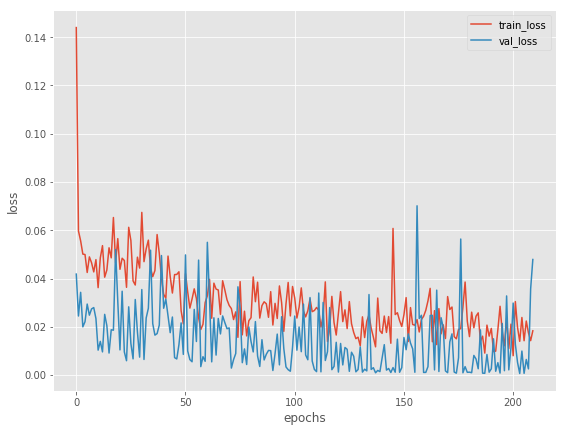

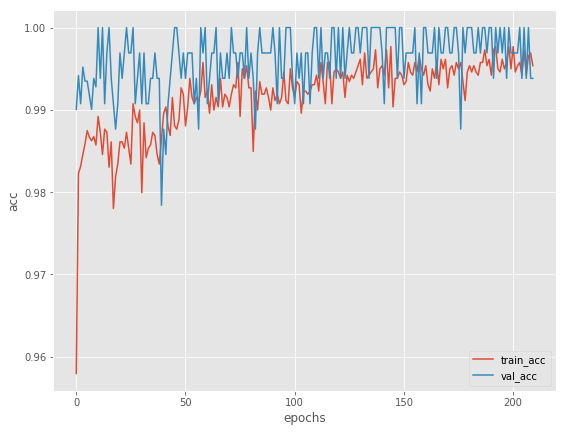

class predictions tensor([1, 3, 0, 0], device='cuda:0')
probability curve wrt angle tensor([[[5.1754e-07, 1.8412e-06, 1.3988e-03, 5.9996e-03, 1.2819e-11,
          2.6236e-05, 1.5154e-06, 8.6862e-05, 2.3138e-06],
         [1.4499e-14, 6.3413e-01, 2.7154e-04, 2.2647e-01, 9.9962e-01,
          9.9481e-01, 6.9815e-01, 4.5998e-01, 9.9894e-01],
         [1.7752e-07, 1.1233e-04, 9.9735e-01, 8.8461e-03, 3.6944e-04,
          2.6232e-03, 3.0182e-01, 5.3950e-01, 4.9985e-04],
         [3.8612e-13, 3.6576e-01, 4.8079e-06, 2.6250e-04, 6.2979e-06,
          1.8130e-03, 1.4637e-07, 2.7831e-04, 2.3084e-04],
         [1.0000e+00, 2.8128e-07, 9.7618e-04, 7.5842e-01, 1.7998e-08,
          7.2588e-04, 2.9208e-05, 1.5626e-04, 3.3053e-04]],

        [[2.9218e-18, 1.0103e-06, 9.9884e-01, 1.8915e-09, 9.9597e-01,
          7.2328e-03, 8.3184e-11, 4.8629e-08, 1.0184e-05],
         [1.7638e-11, 6.0653e-11, 2.5415e-09, 3.5825e-02, 4.0733e-04,
          1.8910e-04, 2.1327e-11, 3.7667e-07, 7.4976e-06],
         [1

In [19]:
def display_results():
    with open("./cnn/cnn_mb_nets_try1.bin", "rb") as f:
        nets = pickle.load(f)
    with open("./cnn/mixed_attn_cnn_9h_try11_mdl.bin",'rb') as f:
        neuralnet = pickle.load(f)
    with open('./cnn/mixed_attn_cnn_9h_try11_train_hist.bin','rb') as f:
        model_hist = pickle.load(f)
    with open('./cnn/mixed_attn_cnn_9h_try11_test_hist.bin','rb') as f:
        test_loss_acc_f1_hist = pickle.load(f)

    model = TrainClassifier(5, model = neuralnet, criterion = CrossEntropyLoss(), batch_size = 64)
    model.history = model_hist
    model.with_graph().display_all()

    def print_p_matrix(x, model):
        x_lst = [torch.nn.Softmax(1)(nn(x))[...,None] for nn in model.nnets]
        x1 = torch.cat(x_lst, dim=2)
        print("probability curve wrt angle", x1)
        return x1

    val_loader =   DataLoader(test_ds1, batch_size=4, shuffle=True)
    n_classes = 5
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        for i in range(9):
            nets[i].eval()
        neuralnet.eval()    
        with torch.set_grad_enabled(False):
            outputs = neuralnet(inputs)
            preds = torch.argmax(outputs, 1)
            print("class predictions", preds)
            o = print_p_matrix(inputs, neuralnet)
        break
    return


display_results()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

epoch:  10%|█         | 1/10 [00:11<01:39, 11.05s/it]


Epoch 001 train loss: 1.2026 valid loss 3.1786 train acc 0.6435 valid acc 0.4198 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:21<01:28, 11.00s/it]


Epoch 002 train loss: 0.4554 valid loss 0.3486 train acc 0.8534 valid acc 0.8796 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:32<01:16, 10.98s/it]


Epoch 003 train loss: 0.3066 valid loss 0.4176 train acc 0.8897 valid acc 0.9074 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:43<01:05, 10.97s/it]


Epoch 004 train loss: 0.3190 valid loss 0.6898 train acc 0.9062 valid acc 0.7901 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:54<00:54, 10.96s/it]


Epoch 005 train loss: 0.4072 valid loss 1.9375 train acc 0.8785 valid acc 0.6574 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:05<00:43, 10.95s/it]


Epoch 006 train loss: 0.2349 valid loss 2.5696 train acc 0.9228 valid acc 0.7716 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:16<00:32, 10.97s/it]


Epoch 007 train loss: 0.1849 valid loss 0.3674 train acc 0.9433 valid acc 0.8827 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:27<00:22, 11.00s/it]


Epoch 008 train loss: 0.1723 valid loss 2.1893 train acc 0.9464 valid acc 0.7469 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:38<00:11, 11.00s/it]


Epoch 009 train loss: 0.1629 valid loss 0.9826 train acc 0.9460 valid acc 0.7623 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.2175 valid loss 0.5477 train acc 0.9360 valid acc 0.8765 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:10<01:38, 10.97s/it]


Epoch 001 train loss: 0.2569 valid loss 0.2620 train acc 0.9417 valid acc 0.9228 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:21<01:27, 10.97s/it]


Epoch 002 train loss: 0.1133 valid loss 0.0675 train acc 0.9633 valid acc 0.9815 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:17, 11.04s/it]


Epoch 003 train loss: 0.0851 valid loss 0.0465 train acc 0.9730 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:44<01:06, 11.04s/it]


Epoch 004 train loss: 0.0611 valid loss 0.0825 train acc 0.9796 valid acc 0.9722 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.04s/it]


Epoch 005 train loss: 0.0714 valid loss 0.0287 train acc 0.9769 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.06s/it]


Epoch 006 train loss: 0.0539 valid loss 0.0088 train acc 0.9838 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.04s/it]


Epoch 007 train loss: 0.0505 valid loss 0.1064 train acc 0.9853 valid acc 0.9660 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.02s/it]


Epoch 008 train loss: 0.0424 valid loss 0.0044 train acc 0.9865 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.02s/it]


Epoch 009 train loss: 0.0300 valid loss 0.1112 train acc 0.9907 valid acc 0.9630 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:50<00:00, 11.03s/it]


Epoch 010 train loss: 0.0217 valid loss 0.5197 train acc 0.9931 valid acc 0.9228 valid f1_sc 0.0000


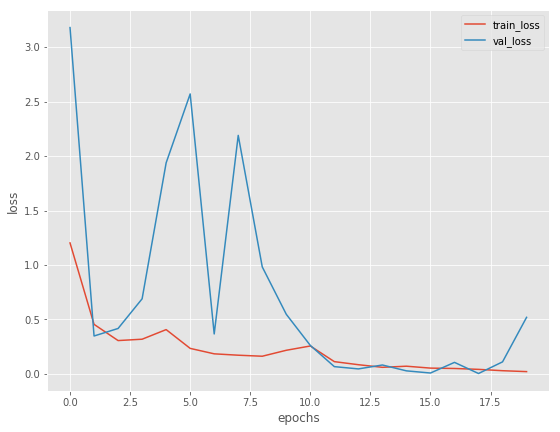

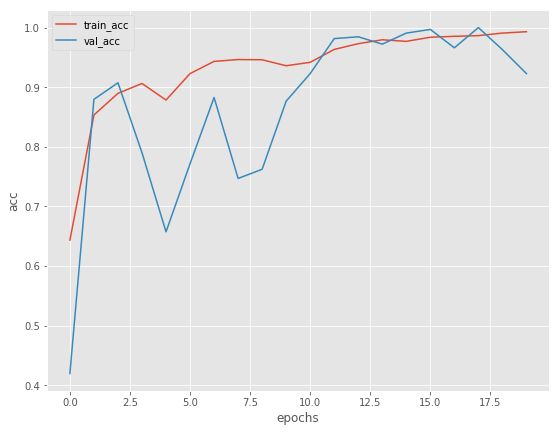

epoch:  10%|█         | 1/10 [00:11<01:42, 11.35s/it]


Epoch 001 train loss: 0.9059 valid loss 4.9771 train acc 0.7126 valid acc 0.4198 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:30, 11.29s/it]


Epoch 002 train loss: 0.5557 valid loss 1.9291 train acc 0.8083 valid acc 0.5926 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:18, 11.23s/it]


Epoch 003 train loss: 0.3929 valid loss 0.8430 train acc 0.8731 valid acc 0.7377 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:07, 11.17s/it]


Epoch 004 train loss: 0.3194 valid loss 1.2126 train acc 0.8893 valid acc 0.7037 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.18s/it]


Epoch 005 train loss: 0.4034 valid loss 28.7276 train acc 0.8727 valid acc 0.1728 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.16s/it]


Epoch 006 train loss: 0.4200 valid loss 1.1697 train acc 0.8746 valid acc 0.7253 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:18<00:33, 11.16s/it]


Epoch 007 train loss: 0.2194 valid loss 0.5684 train acc 0.9255 valid acc 0.8395 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:29<00:22, 11.14s/it]


Epoch 008 train loss: 0.2079 valid loss 0.4485 train acc 0.9309 valid acc 0.8796 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:40<00:11, 11.12s/it]


Epoch 009 train loss: 0.2695 valid loss 0.4022 train acc 0.9252 valid acc 0.9043 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.2444 valid loss 0.2797 train acc 0.9171 valid acc 0.9259 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:40, 11.18s/it]


Epoch 001 train loss: 0.1801 valid loss 0.1520 train acc 0.9433 valid acc 0.9722 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:22<01:29, 11.17s/it]


Epoch 002 train loss: 0.1429 valid loss 0.0975 train acc 0.9560 valid acc 0.9599 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:18, 11.17s/it]


Epoch 003 train loss: 0.1051 valid loss 0.0843 train acc 0.9641 valid acc 0.9660 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:44<01:06, 11.13s/it]


Epoch 004 train loss: 0.0783 valid loss 0.0488 train acc 0.9745 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.10s/it]


Epoch 005 train loss: 0.0710 valid loss 0.0978 train acc 0.9772 valid acc 0.9660 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.08s/it]


Epoch 006 train loss: 0.0493 valid loss 0.0981 train acc 0.9819 valid acc 0.9660 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.06s/it]


Epoch 007 train loss: 0.0475 valid loss 0.0662 train acc 0.9861 valid acc 0.9753 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.05s/it]


Epoch 008 train loss: 0.0322 valid loss 0.0337 train acc 0.9892 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.03s/it]


Epoch 009 train loss: 0.0440 valid loss 0.0871 train acc 0.9861 valid acc 0.9784 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:50<00:00, 11.07s/it]


Epoch 010 train loss: 0.0362 valid loss 0.0325 train acc 0.9892 valid acc 0.9969 valid f1_sc 0.0000


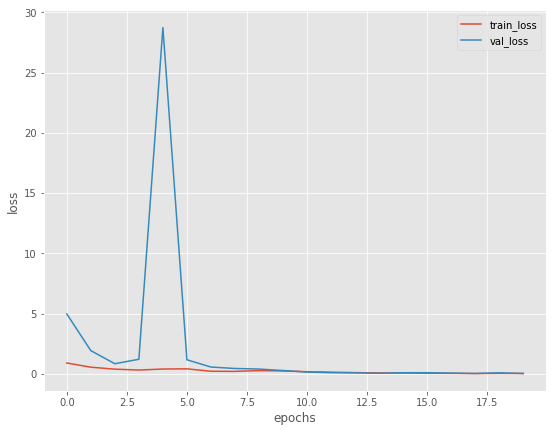

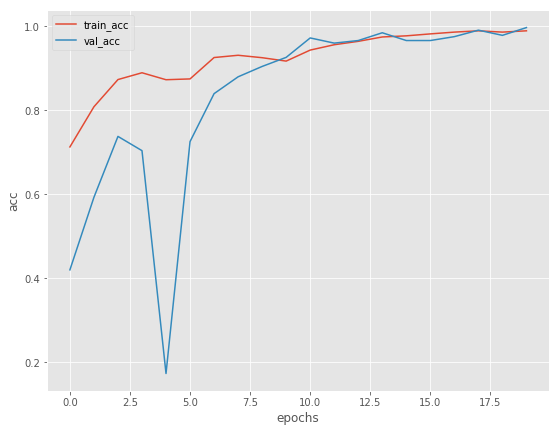

epoch:  10%|█         | 1/10 [00:11<01:40, 11.15s/it]


Epoch 001 train loss: 1.0770 valid loss 2.4311 train acc 0.6840 valid acc 0.1975 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:28, 11.12s/it]


Epoch 002 train loss: 0.5224 valid loss 2.8133 train acc 0.8306 valid acc 0.5648 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:17, 11.08s/it]


Epoch 003 train loss: 0.4763 valid loss 1.0265 train acc 0.8434 valid acc 0.7284 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:06, 11.07s/it]


Epoch 004 train loss: 0.3094 valid loss 0.9253 train acc 0.8974 valid acc 0.7840 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.07s/it]


Epoch 005 train loss: 0.2525 valid loss 0.2665 train acc 0.9132 valid acc 0.9167 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.07s/it]


Epoch 006 train loss: 0.2500 valid loss 0.2996 train acc 0.9217 valid acc 0.8951 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.08s/it]


Epoch 007 train loss: 0.3007 valid loss 1.4201 train acc 0.9194 valid acc 0.6481 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.07s/it]


Epoch 008 train loss: 0.3459 valid loss 0.3763 train acc 0.8843 valid acc 0.8302 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.06s/it]


Epoch 009 train loss: 0.2146 valid loss 0.7801 train acc 0.9252 valid acc 0.8549 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.2367 valid loss 0.1783 train acc 0.9182 valid acc 0.9228 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:40, 11.21s/it]


Epoch 001 train loss: 0.2234 valid loss 0.3198 train acc 0.9282 valid acc 0.8580 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:22<01:29, 11.19s/it]


Epoch 002 train loss: 0.1415 valid loss 0.4707 train acc 0.9533 valid acc 0.8272 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:18, 11.23s/it]


Epoch 003 train loss: 0.1012 valid loss 0.0748 train acc 0.9688 valid acc 0.9753 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:44<01:07, 11.23s/it]


Epoch 004 train loss: 0.0829 valid loss 0.0660 train acc 0.9745 valid acc 0.9815 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.17s/it]


Epoch 005 train loss: 0.0833 valid loss 0.1870 train acc 0.9765 valid acc 0.9537 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.13s/it]


Epoch 006 train loss: 0.0582 valid loss 0.0927 train acc 0.9807 valid acc 0.9753 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:18<00:33, 11.17s/it]


Epoch 007 train loss: 0.0524 valid loss 0.0068 train acc 0.9815 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:29<00:22, 11.16s/it]


Epoch 008 train loss: 0.0259 valid loss 0.0053 train acc 0.9907 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:40<00:11, 11.13s/it]


Epoch 009 train loss: 0.0233 valid loss 0.0307 train acc 0.9915 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:51<00:00, 11.15s/it]


Epoch 010 train loss: 0.0346 valid loss 0.0562 train acc 0.9892 valid acc 0.9722 valid f1_sc 0.0000


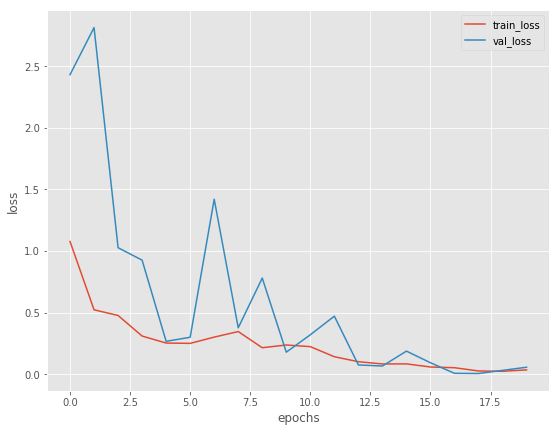

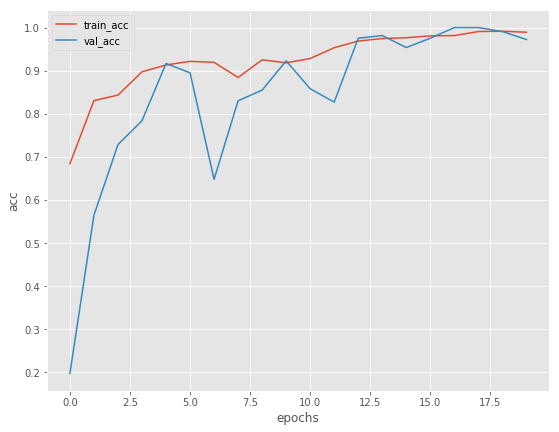

epoch:  10%|█         | 1/10 [00:11<01:40, 11.20s/it]


Epoch 001 train loss: 1.0303 valid loss 1.6009 train acc 0.6767 valid acc 0.5062 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:30, 11.28s/it]


Epoch 002 train loss: 0.4949 valid loss 0.9979 train acc 0.8341 valid acc 0.7809 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:18, 11.20s/it]


Epoch 003 train loss: 0.3457 valid loss 0.3416 train acc 0.8881 valid acc 0.8735 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:06, 11.16s/it]


Epoch 004 train loss: 0.2889 valid loss 0.2842 train acc 0.8997 valid acc 0.8951 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.12s/it]


Epoch 005 train loss: 0.2609 valid loss 3.1896 train acc 0.9190 valid acc 0.5123 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.09s/it]


Epoch 006 train loss: 0.2681 valid loss 0.2311 train acc 0.9213 valid acc 0.9167 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.07s/it]


Epoch 007 train loss: 0.1694 valid loss 0.4597 train acc 0.9460 valid acc 0.8549 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.06s/it]


Epoch 008 train loss: 0.2066 valid loss 1.0701 train acc 0.9336 valid acc 0.7469 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.05s/it]


Epoch 009 train loss: 0.1933 valid loss 0.4289 train acc 0.9375 valid acc 0.8827 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1852 valid loss 0.1794 train acc 0.9387 valid acc 0.9383 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:39, 11.01s/it]


Epoch 001 train loss: 0.1675 valid loss 0.0743 train acc 0.9487 valid acc 0.9815 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:21<01:28, 11.00s/it]


Epoch 002 train loss: 0.1184 valid loss 0.1447 train acc 0.9630 valid acc 0.9414 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:32<01:16, 10.96s/it]


Epoch 003 train loss: 0.0825 valid loss 0.0938 train acc 0.9734 valid acc 0.9753 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:43<01:05, 10.91s/it]


Epoch 004 train loss: 0.0678 valid loss 0.0610 train acc 0.9799 valid acc 0.9753 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:54<00:54, 10.88s/it]


Epoch 005 train loss: 0.0816 valid loss 0.2060 train acc 0.9765 valid acc 0.9352 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:05<00:43, 10.89s/it]


Epoch 006 train loss: 0.0571 valid loss 0.0904 train acc 0.9826 valid acc 0.9599 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:16<00:32, 10.99s/it]


Epoch 007 train loss: 0.0382 valid loss 0.0128 train acc 0.9873 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:27<00:21, 10.97s/it]


Epoch 008 train loss: 0.0425 valid loss 0.0219 train acc 0.9877 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:38<00:10, 10.98s/it]


Epoch 009 train loss: 0.0351 valid loss 0.0198 train acc 0.9907 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:49<00:00, 10.94s/it]


Epoch 010 train loss: 0.0334 valid loss 0.0060 train acc 0.9900 valid acc 0.9969 valid f1_sc 0.0000


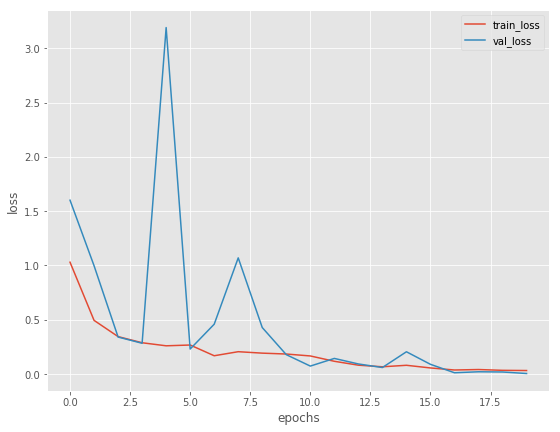

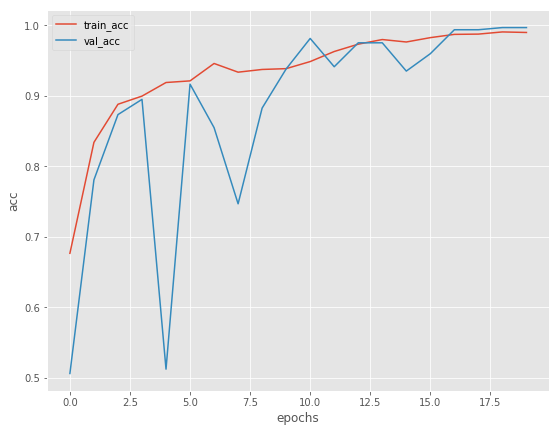

epoch:  10%|█         | 1/10 [00:11<01:39, 11.05s/it]


Epoch 001 train loss: 1.2141 valid loss 1.7380 train acc 0.6427 valid acc 0.5000 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:21<01:27, 10.99s/it]


Epoch 002 train loss: 0.5429 valid loss 0.3671 train acc 0.8148 valid acc 0.8364 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:32<01:16, 10.99s/it]


Epoch 003 train loss: 0.4281 valid loss 0.3793 train acc 0.8530 valid acc 0.8457 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:43<01:05, 10.96s/it]


Epoch 004 train loss: 0.2878 valid loss 0.9677 train acc 0.8985 valid acc 0.7870 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:54<00:55, 11.00s/it]


Epoch 005 train loss: 0.3631 valid loss 0.6001 train acc 0.8854 valid acc 0.8179 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.05s/it]


Epoch 006 train loss: 0.3289 valid loss 0.2121 train acc 0.9001 valid acc 0.9259 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.03s/it]


Epoch 007 train loss: 0.2899 valid loss 0.3774 train acc 0.9090 valid acc 0.8981 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:27<00:21, 10.95s/it]


Epoch 008 train loss: 0.2236 valid loss 1.1703 train acc 0.9182 valid acc 0.7469 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:38<00:10, 10.89s/it]


Epoch 009 train loss: 0.1441 valid loss 0.1040 train acc 0.9514 valid acc 0.9722 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1581 valid loss 0.8465 train acc 0.9510 valid acc 0.8580 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:10<01:37, 10.83s/it]


Epoch 001 train loss: 0.1712 valid loss 0.5454 train acc 0.9425 valid acc 0.8889 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:21<01:26, 10.85s/it]


Epoch 002 train loss: 0.1271 valid loss 0.1710 train acc 0.9587 valid acc 0.9352 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:32<01:16, 10.86s/it]


Epoch 003 train loss: 0.1006 valid loss 1.5237 train acc 0.9668 valid acc 0.7531 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:43<01:05, 10.91s/it]


Epoch 004 train loss: 0.0666 valid loss 0.0629 train acc 0.9815 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:54<00:54, 10.98s/it]


Epoch 005 train loss: 0.0750 valid loss 0.0311 train acc 0.9769 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:05<00:44, 11.00s/it]


Epoch 006 train loss: 0.0611 valid loss 0.0209 train acc 0.9796 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:16<00:33, 11.04s/it]


Epoch 007 train loss: 0.0412 valid loss 0.0185 train acc 0.9857 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.20s/it]


Epoch 008 train loss: 0.0341 valid loss 0.0272 train acc 0.9900 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:40<00:11, 11.29s/it]


Epoch 009 train loss: 0.0295 valid loss 0.3903 train acc 0.9884 valid acc 0.9105 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:51<00:00, 11.10s/it]


Epoch 010 train loss: 0.0324 valid loss 0.6136 train acc 0.9904 valid acc 0.9136 valid f1_sc 0.0000


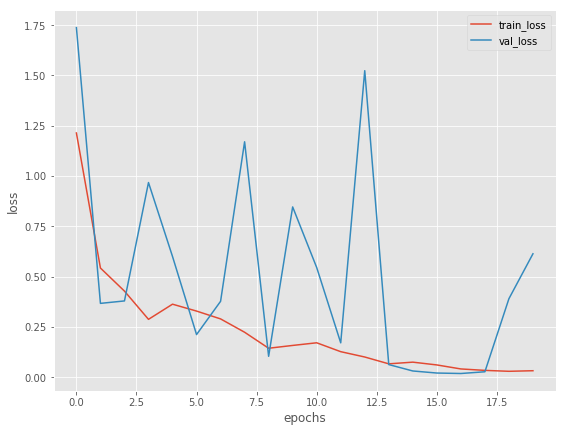

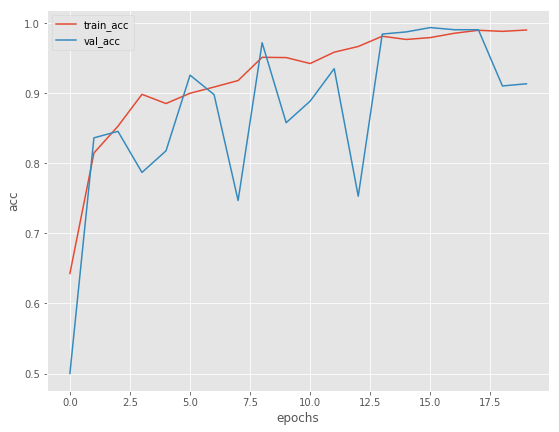

epoch:  10%|█         | 1/10 [00:11<01:40, 11.14s/it]


Epoch 001 train loss: 1.1391 valid loss 1.5468 train acc 0.6701 valid acc 0.4722 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:29, 11.14s/it]


Epoch 002 train loss: 0.4900 valid loss 1.2848 train acc 0.8376 valid acc 0.7160 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:17, 11.14s/it]


Epoch 003 train loss: 0.3452 valid loss 0.9345 train acc 0.8870 valid acc 0.7099 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:06, 11.10s/it]


Epoch 004 train loss: 0.2587 valid loss 0.8713 train acc 0.9105 valid acc 0.7963 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.09s/it]


Epoch 005 train loss: 0.3797 valid loss 1.8801 train acc 0.8823 valid acc 0.6204 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.08s/it]


Epoch 006 train loss: 0.4380 valid loss 0.2669 train acc 0.8546 valid acc 0.9074 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.05s/it]


Epoch 007 train loss: 0.2574 valid loss 0.1997 train acc 0.9213 valid acc 0.9198 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.06s/it]


Epoch 008 train loss: 0.2684 valid loss 0.9838 train acc 0.9124 valid acc 0.7469 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.03s/it]


Epoch 009 train loss: 0.1634 valid loss 0.4801 train acc 0.9410 valid acc 0.8519 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1582 valid loss 1.1236 train acc 0.9475 valid acc 0.7932 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:40, 11.14s/it]


Epoch 001 train loss: 0.1623 valid loss 0.1307 train acc 0.9437 valid acc 0.9414 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:22<01:28, 11.11s/it]


Epoch 002 train loss: 0.1073 valid loss 0.4815 train acc 0.9633 valid acc 0.9043 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:17, 11.09s/it]


Epoch 003 train loss: 0.1071 valid loss 0.1408 train acc 0.9688 valid acc 0.9568 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:44<01:06, 11.08s/it]


Epoch 004 train loss: 0.0784 valid loss 0.4438 train acc 0.9776 valid acc 0.8858 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.06s/it]


Epoch 005 train loss: 0.0779 valid loss 0.0802 train acc 0.9711 valid acc 0.9722 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.13s/it]


Epoch 006 train loss: 0.0480 valid loss 0.0235 train acc 0.9857 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.10s/it]


Epoch 007 train loss: 0.0419 valid loss 0.4128 train acc 0.9861 valid acc 0.9414 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.07s/it]


Epoch 008 train loss: 0.0376 valid loss 0.0144 train acc 0.9884 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.07s/it]


Epoch 009 train loss: 0.0340 valid loss 2.5231 train acc 0.9907 valid acc 0.6265 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:50<00:00, 11.07s/it]


Epoch 010 train loss: 0.0240 valid loss 0.4339 train acc 0.9915 valid acc 0.9506 valid f1_sc 0.0000


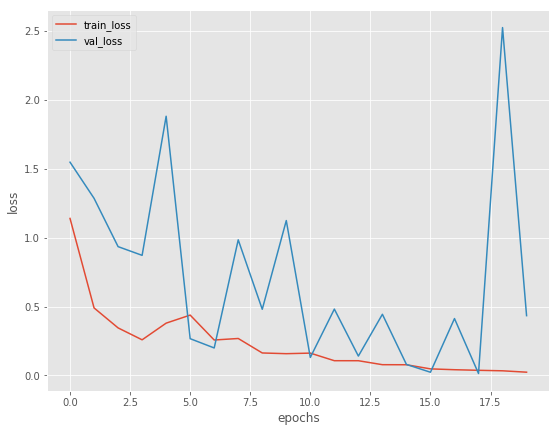

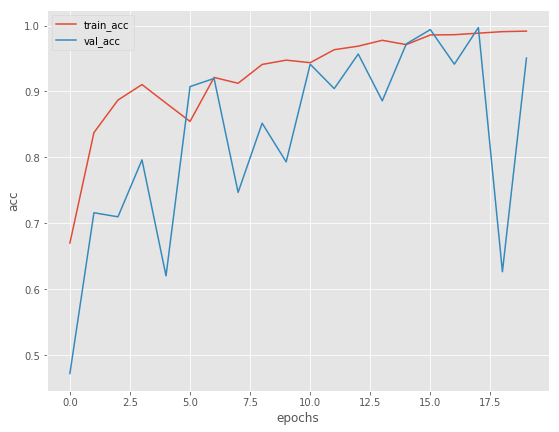

epoch:  10%|█         | 1/10 [00:11<01:40, 11.16s/it]


Epoch 001 train loss: 1.0122 valid loss 4.6462 train acc 0.7245 valid acc 0.4228 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:28, 11.12s/it]


Epoch 002 train loss: 0.4531 valid loss 0.2738 train acc 0.8499 valid acc 0.9012 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:18, 11.15s/it]


Epoch 003 train loss: 0.3471 valid loss 0.8298 train acc 0.8943 valid acc 0.8025 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:07, 11.21s/it]


Epoch 004 train loss: 0.2664 valid loss 0.5254 train acc 0.9070 valid acc 0.8457 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:56<00:56, 11.24s/it]


Epoch 005 train loss: 0.2773 valid loss 1.9427 train acc 0.9124 valid acc 0.6481 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:07<00:44, 11.25s/it]


Epoch 006 train loss: 0.4531 valid loss 3.8353 train acc 0.8673 valid acc 0.4043 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:18<00:33, 11.23s/it]


Epoch 007 train loss: 0.2001 valid loss 8.6951 train acc 0.9313 valid acc 0.4259 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:29<00:22, 11.18s/it]


Epoch 008 train loss: 0.2101 valid loss 0.7357 train acc 0.9344 valid acc 0.7963 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:41<00:11, 11.27s/it]


Epoch 009 train loss: 0.1110 valid loss 0.4936 train acc 0.9618 valid acc 0.8549 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1116 valid loss 0.1490 train acc 0.9626 valid acc 0.9537 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:39, 11.00s/it]


Epoch 001 train loss: 0.1423 valid loss 0.9183 train acc 0.9552 valid acc 0.7994 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:22<01:28, 11.01s/it]


Epoch 002 train loss: 0.1087 valid loss 0.9691 train acc 0.9680 valid acc 0.7716 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:17, 11.02s/it]


Epoch 003 train loss: 0.0754 valid loss 0.1650 train acc 0.9753 valid acc 0.9568 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:44<01:06, 11.04s/it]


Epoch 004 train loss: 0.0506 valid loss 0.0977 train acc 0.9838 valid acc 0.9660 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.03s/it]


Epoch 005 train loss: 0.0657 valid loss 0.1100 train acc 0.9807 valid acc 0.9722 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:06<00:44, 11.03s/it]


Epoch 006 train loss: 0.0395 valid loss 0.0605 train acc 0.9877 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:17<00:33, 11.04s/it]


Epoch 007 train loss: 0.0302 valid loss 0.0201 train acc 0.9911 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:28<00:22, 11.05s/it]


Epoch 008 train loss: 0.0268 valid loss 0.0273 train acc 0.9915 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.05s/it]


Epoch 009 train loss: 0.0271 valid loss 0.0058 train acc 0.9919 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:50<00:00, 11.05s/it]


Epoch 010 train loss: 0.0172 valid loss 0.0014 train acc 0.9950 valid acc 1.0000 valid f1_sc 0.0000


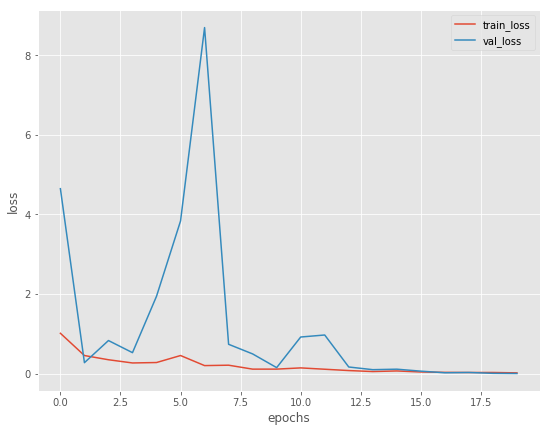

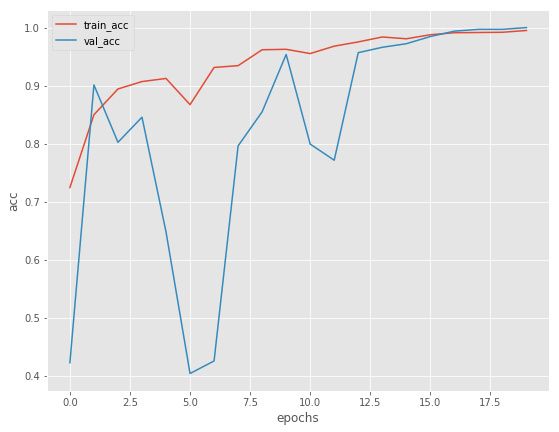

epoch:  10%|█         | 1/10 [00:11<01:39, 11.11s/it]


Epoch 001 train loss: 1.0922 valid loss 1.6796 train acc 0.6806 valid acc 0.5123 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:28, 11.09s/it]


Epoch 002 train loss: 0.5643 valid loss 3.7778 train acc 0.8299 valid acc 0.5247 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:17, 11.07s/it]


Epoch 003 train loss: 0.3946 valid loss 1.0151 train acc 0.8684 valid acc 0.7500 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:06, 11.05s/it]


Epoch 004 train loss: 0.3761 valid loss 0.9710 train acc 0.8870 valid acc 0.7222 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.13s/it]


Epoch 005 train loss: 0.3136 valid loss 1.5380 train acc 0.8889 valid acc 0.5586 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:07<00:45, 11.31s/it]


Epoch 006 train loss: 0.2888 valid loss 0.9224 train acc 0.9070 valid acc 0.7778 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:18<00:33, 11.25s/it]


Epoch 007 train loss: 0.2641 valid loss 1.4634 train acc 0.9155 valid acc 0.7407 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:29<00:22, 11.23s/it]


Epoch 008 train loss: 0.3391 valid loss 3.8859 train acc 0.9008 valid acc 0.4969 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:40<00:11, 11.18s/it]


Epoch 009 train loss: 0.2090 valid loss 0.1753 train acc 0.9348 valid acc 0.9444 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1474 valid loss 0.4434 train acc 0.9495 valid acc 0.8735 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:39, 11.01s/it]


Epoch 001 train loss: 0.1594 valid loss 1.2501 train acc 0.9460 valid acc 0.7006 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:22<01:29, 11.16s/it]


Epoch 002 train loss: 0.1206 valid loss 0.1247 train acc 0.9599 valid acc 0.9599 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:33<01:18, 11.19s/it]


Epoch 003 train loss: 0.0889 valid loss 0.2423 train acc 0.9703 valid acc 0.9290 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:45<01:07, 11.32s/it]


Epoch 004 train loss: 0.0618 valid loss 0.1970 train acc 0.9799 valid acc 0.9444 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:56<00:56, 11.35s/it]


Epoch 005 train loss: 0.0562 valid loss 0.0931 train acc 0.9799 valid acc 0.9815 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:07<00:44, 11.25s/it]


Epoch 006 train loss: 0.0523 valid loss 0.0408 train acc 0.9823 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:18<00:33, 11.18s/it]


Epoch 007 train loss: 0.0489 valid loss 0.1168 train acc 0.9865 valid acc 0.9599 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:29<00:22, 11.12s/it]


Epoch 008 train loss: 0.0364 valid loss 0.1197 train acc 0.9877 valid acc 0.9599 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:40<00:11, 11.08s/it]


Epoch 009 train loss: 0.0339 valid loss 0.0098 train acc 0.9904 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:51<00:00, 11.18s/it]


Epoch 010 train loss: 0.0296 valid loss 0.0137 train acc 0.9927 valid acc 0.9969 valid f1_sc 0.0000


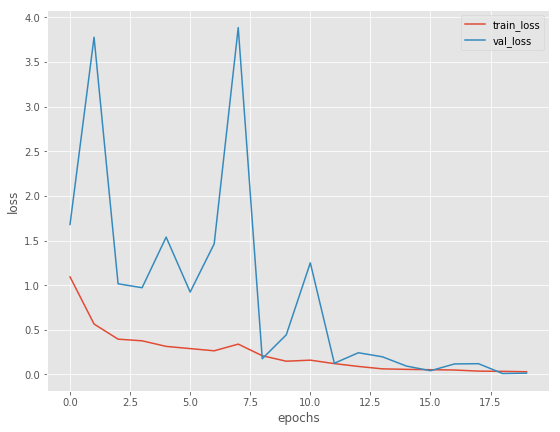

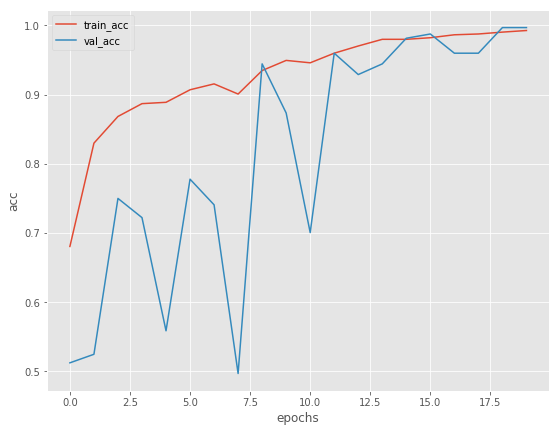

epoch:  10%|█         | 1/10 [00:11<01:40, 11.14s/it]


Epoch 001 train loss: 1.2568 valid loss 2.4441 train acc 0.6512 valid acc 0.4290 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [00:22<01:28, 11.08s/it]


Epoch 002 train loss: 0.4578 valid loss 0.8550 train acc 0.8476 valid acc 0.7407 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [00:33<01:17, 11.06s/it]


Epoch 003 train loss: 0.4444 valid loss 1.8365 train acc 0.8530 valid acc 0.7809 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [00:44<01:06, 11.03s/it]


Epoch 004 train loss: 0.3694 valid loss 0.6777 train acc 0.8727 valid acc 0.7531 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [00:55<00:55, 11.00s/it]


Epoch 005 train loss: 0.2561 valid loss 0.2948 train acc 0.9124 valid acc 0.8920 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [01:05<00:43, 10.98s/it]


Epoch 006 train loss: 0.3373 valid loss 0.4987 train acc 0.9016 valid acc 0.8642 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [01:16<00:32, 10.97s/it]


Epoch 007 train loss: 0.2717 valid loss 0.1940 train acc 0.9113 valid acc 0.9352 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [01:27<00:21, 10.97s/it]


Epoch 008 train loss: 0.2375 valid loss 0.8974 train acc 0.9171 valid acc 0.8488 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [01:38<00:10, 10.97s/it]


Epoch 009 train loss: 0.1870 valid loss 0.8343 train acc 0.9425 valid acc 0.8179 valid f1_sc 0.0000


epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 010 train loss: 0.1746 valid loss 0.2401 train acc 0.9406 valid acc 0.9198 valid f1_sc 0.0000
LR =  0.002


epoch:  10%|█         | 1/10 [00:11<01:38, 11.00s/it]


Epoch 001 train loss: 0.1888 valid loss 0.1163 train acc 0.9433 valid acc 0.9537 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  20%|██        | 2/10 [00:21<01:27, 10.99s/it]


Epoch 002 train loss: 0.1171 valid loss 0.9727 train acc 0.9591 valid acc 0.8210 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  30%|███       | 3/10 [00:32<01:16, 10.98s/it]


Epoch 003 train loss: 0.1035 valid loss 0.0862 train acc 0.9668 valid acc 0.9815 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  40%|████      | 4/10 [00:43<01:05, 11.00s/it]


Epoch 004 train loss: 0.0833 valid loss 0.0525 train acc 0.9745 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:  50%|█████     | 5/10 [00:54<00:54, 10.99s/it]


Epoch 005 train loss: 0.0654 valid loss 0.0891 train acc 0.9784 valid acc 0.9722 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  60%|██████    | 6/10 [01:05<00:43, 10.99s/it]


Epoch 006 train loss: 0.0529 valid loss 0.4748 train acc 0.9834 valid acc 0.9043 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  70%|███████   | 7/10 [01:16<00:32, 10.99s/it]


Epoch 007 train loss: 0.0371 valid loss 0.0266 train acc 0.9842 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  80%|████████  | 8/10 [01:27<00:21, 10.98s/it]


Epoch 008 train loss: 0.0507 valid loss 0.0249 train acc 0.9830 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  90%|█████████ | 9/10 [01:38<00:10, 10.97s/it]


Epoch 009 train loss: 0.0432 valid loss 0.0303 train acc 0.9873 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch: 100%|██████████| 10/10 [01:49<00:00, 10.98s/it]


Epoch 010 train loss: 0.0289 valid loss 0.0232 train acc 0.9892 valid acc 0.9907 valid f1_sc 0.0000


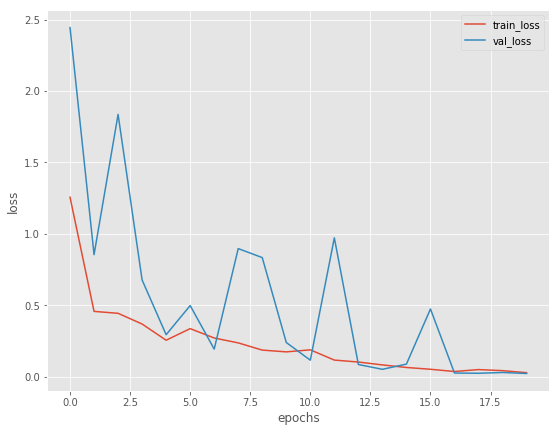

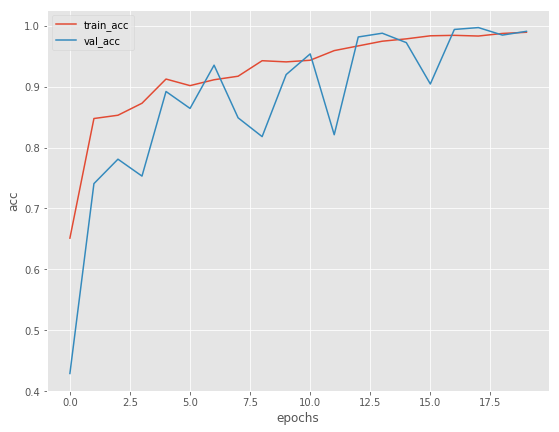

9


In [12]:
# nets = train_cnn_heads(5, ds_list)
# print(len(nets))

epoch:  10%|█         | 1/10 [04:16<38:32, 256.99s/it]


Epoch 001 train loss: 0.1440 valid loss 0.0418 train acc 0.9579 valid acc 0.9901 valid f1_sc 0.0000


epoch:  20%|██        | 2/10 [08:40<34:30, 258.83s/it]


Epoch 002 train loss: 0.0597 valid loss 0.0245 train acc 0.9823 valid acc 0.9942 valid f1_sc 0.0000


epoch:  30%|███       | 3/10 [13:07<30:29, 261.36s/it]


Epoch 003 train loss: 0.0556 valid loss 0.0343 train acc 0.9832 valid acc 0.9907 valid f1_sc 0.0000


epoch:  40%|████      | 4/10 [17:36<26:22, 263.69s/it]


Epoch 004 train loss: 0.0501 valid loss 0.0200 train acc 0.9846 valid acc 0.9952 valid f1_sc 0.0000


epoch:  50%|█████     | 5/10 [22:07<22:09, 265.94s/it]


Epoch 005 train loss: 0.0499 valid loss 0.0221 train acc 0.9859 valid acc 0.9935 valid f1_sc 0.0000


epoch:  60%|██████    | 6/10 [26:39<17:51, 267.82s/it]


Epoch 006 train loss: 0.0425 valid loss 0.0294 train acc 0.9875 valid acc 0.9935 valid f1_sc 0.0000


epoch:  70%|███████   | 7/10 [31:11<13:26, 269.00s/it]


Epoch 007 train loss: 0.0490 valid loss 0.0248 train acc 0.9867 valid acc 0.9918 valid f1_sc 0.0000


epoch:  80%|████████  | 8/10 [35:43<08:59, 269.98s/it]


Epoch 008 train loss: 0.0465 valid loss 0.0274 train acc 0.9862 valid acc 0.9901 valid f1_sc 0.0000


epoch:  90%|█████████ | 9/10 [40:17<04:30, 270.93s/it]


Epoch 009 train loss: 0.0427 valid loss 0.0280 train acc 0.9868 valid acc 0.9938 valid f1_sc 0.0000


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 010 train loss: 0.0478 valid loss 0.0234 train acc 0.9857 valid acc 0.9928 valid f1_sc 0.0000
CD_1
LR =  0.002


epoch:  20%|██        | 1/5 [00:35<02:22, 35.62s/it]


Epoch 001 train loss: 0.0362 valid loss 0.0103 train acc 0.9892 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0016326530612244896


epoch:  40%|████      | 2/5 [01:11<01:46, 35.56s/it]


Epoch 002 train loss: 0.0486 valid loss 0.0139 train acc 0.9873 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0013793103448275863


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.56s/it]


Epoch 003 train loss: 0.0536 valid loss 0.0096 train acc 0.9846 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0011940298507462687


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.57s/it]


Epoch 004 train loss: 0.0406 valid loss 0.0251 train acc 0.9877 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0010526315789473684


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0435 valid loss 0.0205 train acc 0.9873 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0009411764705882353


epoch:  20%|██        | 1/5 [00:35<02:21, 35.49s/it]


Epoch 001 train loss: 0.0527 valid loss 0.0091 train acc 0.9830 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.000851063829787234


epoch:  40%|████      | 2/5 [01:11<01:46, 35.54s/it]


Epoch 002 train loss: 0.0486 valid loss 0.0188 train acc 0.9861 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0007766990291262135


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.55s/it]


Epoch 003 train loss: 0.0653 valid loss 0.0186 train acc 0.9780 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0007142857142857144


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.59s/it]


Epoch 004 train loss: 0.0465 valid loss 0.0520 train acc 0.9819 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.0006611570247933885


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0565 valid loss 0.0305 train acc 0.9834 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0006153846153846154


epoch:  20%|██        | 1/5 [00:35<02:22, 35.66s/it]


Epoch 001 train loss: 0.0438 valid loss 0.0104 train acc 0.9861 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0005755395683453237


epoch:  40%|████      | 2/5 [01:11<01:46, 35.60s/it]


Epoch 002 train loss: 0.0484 valid loss 0.0347 train acc 0.9861 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0005405405405405405


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.59s/it]


Epoch 003 train loss: 0.0475 valid loss 0.0096 train acc 0.9853 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0005095541401273885


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.59s/it]


Epoch 004 train loss: 0.0364 valid loss 0.0059 train acc 0.9873 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00048192771084337347


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0612 valid loss 0.0283 train acc 0.9853 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00045714285714285713


epoch:  20%|██        | 1/5 [00:35<02:22, 35.51s/it]


Epoch 001 train loss: 0.0557 valid loss 0.0130 train acc 0.9834 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0004347826086956522


epoch:  40%|████      | 2/5 [01:11<01:46, 35.56s/it]


Epoch 002 train loss: 0.0390 valid loss 0.0067 train acc 0.9907 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0004145077720207254


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.59s/it]


Epoch 003 train loss: 0.0373 valid loss 0.0313 train acc 0.9892 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00039603960396039607


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.63s/it]


Epoch 004 train loss: 0.0488 valid loss 0.0178 train acc 0.9884 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0003791469194312796


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0443 valid loss 0.0074 train acc 0.9900 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00036363636363636367


epoch:  20%|██        | 1/5 [00:35<02:23, 35.75s/it]


Epoch 001 train loss: 0.0674 valid loss 0.0354 train acc 0.9799 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00034934497816593884


epoch:  40%|████      | 2/5 [01:11<01:47, 35.73s/it]


Epoch 002 train loss: 0.0470 valid loss 0.0065 train acc 0.9884 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0003361344537815126


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.77s/it]


Epoch 003 train loss: 0.0523 valid loss 0.0236 train acc 0.9842 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00032388663967611336


epoch:  80%|████████  | 4/5 [02:23<00:35, 35.76s/it]


Epoch 004 train loss: 0.0559 valid loss 0.0277 train acc 0.9853 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0003125


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0443 valid loss 0.0517 train acc 0.9857 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0003018867924528302


epoch:  20%|██        | 1/5 [00:35<02:22, 35.72s/it]


Epoch 001 train loss: 0.0408 valid loss 0.0213 train acc 0.9873 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.000291970802919708


epoch:  40%|████      | 2/5 [01:11<01:47, 35.76s/it]


Epoch 002 train loss: 0.0433 valid loss 0.0165 train acc 0.9869 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0002826855123674912


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.76s/it]


Epoch 003 train loss: 0.0582 valid loss 0.0172 train acc 0.9846 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00027397260273972606


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.71s/it]


Epoch 004 train loss: 0.0504 valid loss 0.0207 train acc 0.9834 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00026578073089701


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0399 valid loss 0.0495 train acc 0.9865 valid acc 0.9784 valid f1_sc 0.0000
LR =  0.00025806451612903227


epoch:  20%|██        | 1/5 [00:35<02:22, 35.65s/it]


Epoch 001 train loss: 0.0335 valid loss 0.0277 train acc 0.9896 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.00025078369905956113


epoch:  40%|████      | 2/5 [01:11<01:47, 35.73s/it]


Epoch 002 train loss: 0.0318 valid loss 0.0315 train acc 0.9904 valid acc 0.9846 valid f1_sc 0.0000
LR =  0.00024390243902439027


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.74s/it]


Epoch 003 train loss: 0.0493 valid loss 0.0245 train acc 0.9880 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0002373887240356083


epoch:  80%|████████  | 4/5 [02:23<00:35, 35.75s/it]


Epoch 004 train loss: 0.0407 valid loss 0.0176 train acc 0.9869 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00023121387283236994


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0340 valid loss 0.0240 train acc 0.9915 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00022535211267605634


epoch:  20%|██        | 1/5 [00:35<02:22, 35.73s/it]


Epoch 001 train loss: 0.0416 valid loss 0.0072 train acc 0.9880 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00021978021978021978


epoch:  40%|████      | 2/5 [01:11<01:47, 35.69s/it]


Epoch 002 train loss: 0.0417 valid loss 0.0067 train acc 0.9877 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00021447721179624664


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.67s/it]


Epoch 003 train loss: 0.0428 valid loss 0.0126 train acc 0.9888 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0002094240837696335


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.72s/it]


Epoch 004 train loss: 0.0266 valid loss 0.0216 train acc 0.9927 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00020460358056265986


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0212 valid loss 0.0086 train acc 0.9919 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0002


epoch:  20%|██        | 1/5 [00:35<02:22, 35.65s/it]


Epoch 001 train loss: 0.0420 valid loss 0.0498 train acc 0.9880 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0002


epoch:  40%|████      | 2/5 [01:11<01:46, 35.65s/it]


Epoch 002 train loss: 0.0345 valid loss 0.0100 train acc 0.9904 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001997


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.66s/it]


Epoch 003 train loss: 0.0277 valid loss 0.0064 train acc 0.9938 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00019940000000000002


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.65s/it]


Epoch 004 train loss: 0.0315 valid loss 0.0055 train acc 0.9915 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00019910000000000001


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0357 valid loss 0.0272 train acc 0.9907 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0001988


epoch:  20%|██        | 1/5 [00:30<02:02, 30.75s/it]


Epoch 001 train loss: 0.0317 valid loss 0.0139 train acc 0.9915 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001985


epoch:  40%|████      | 2/5 [01:01<01:32, 30.81s/it]


Epoch 002 train loss: 0.0238 valid loss 0.0476 train acc 0.9911 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.00019820000000000002


epoch:  60%|██████    | 3/5 [01:32<01:01, 30.81s/it]


Epoch 003 train loss: 0.0189 valid loss 0.0035 train acc 0.9923 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001979


epoch:  80%|████████  | 4/5 [02:03<00:30, 30.81s/it]


Epoch 004 train loss: 0.0210 valid loss 0.0076 train acc 0.9958 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001976


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0300 valid loss 0.0057 train acc 0.9915 valid acc 1.0000 valid f1_sc 0.0000
CD_2
LR =  0.0001973


epoch:  20%|██        | 1/5 [00:35<02:22, 35.71s/it]


Epoch 001 train loss: 0.0328 valid loss 0.0550 train acc 0.9923 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00019700000000000002


epoch:  40%|████      | 2/5 [01:11<01:47, 35.70s/it]


Epoch 002 train loss: 0.0396 valid loss 0.0313 train acc 0.9896 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001967


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.70s/it]


Epoch 003 train loss: 0.0235 valid loss 0.0055 train acc 0.9931 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001964


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.70s/it]


Epoch 004 train loss: 0.0381 valid loss 0.0237 train acc 0.9900 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001961


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0356 valid loss 0.0083 train acc 0.9915 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00019580000000000002


epoch:  20%|██        | 1/5 [00:35<02:22, 35.66s/it]


Epoch 001 train loss: 0.0352 valid loss 0.0234 train acc 0.9904 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0001955


epoch:  40%|████      | 2/5 [01:11<01:47, 35.67s/it]


Epoch 002 train loss: 0.0251 valid loss 0.0170 train acc 0.9938 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001952


epoch:  60%|██████    | 3/5 [01:46<01:11, 35.65s/it]


Epoch 003 train loss: 0.0391 valid loss 0.0245 train acc 0.9904 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00019490000000000002


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.66s/it]


Epoch 004 train loss: 0.0353 valid loss 0.0217 train acc 0.9919 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00019460000000000001


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0312 valid loss 0.0192 train acc 0.9915 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001943


epoch:  20%|██        | 1/5 [00:35<02:23, 35.79s/it]


Epoch 001 train loss: 0.0288 valid loss 0.0195 train acc 0.9904 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.000194


epoch:  40%|████      | 2/5 [01:11<01:47, 35.74s/it]


Epoch 002 train loss: 0.0275 valid loss 0.0029 train acc 0.9919 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00019370000000000002


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.71s/it]


Epoch 003 train loss: 0.0230 valid loss 0.0064 train acc 0.9931 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001934


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.72s/it]


Epoch 004 train loss: 0.0262 valid loss 0.0089 train acc 0.9927 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001931


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0156 valid loss 0.0366 train acc 0.9958 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001928


epoch:  20%|██        | 1/5 [00:35<02:23, 35.80s/it]


Epoch 001 train loss: 0.0387 valid loss 0.0277 train acc 0.9892 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00019250000000000002


epoch:  40%|████      | 2/5 [01:11<01:47, 35.75s/it]


Epoch 002 train loss: 0.0167 valid loss 0.0051 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001922


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.74s/it]


Epoch 003 train loss: 0.0264 valid loss 0.0108 train acc 0.9938 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001919


epoch:  80%|████████  | 4/5 [02:22<00:35, 35.76s/it]


Epoch 004 train loss: 0.0162 valid loss 0.0044 train acc 0.9954 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00019160000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0225 valid loss 0.0199 train acc 0.9927 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00019130000000000001


epoch:  20%|██        | 1/5 [00:35<02:23, 35.89s/it]


Epoch 001 train loss: 0.0238 valid loss 0.0139 train acc 0.9927 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.000191


epoch:  40%|████      | 2/5 [01:11<01:47, 35.87s/it]


Epoch 002 train loss: 0.0406 valid loss 0.0096 train acc 0.9850 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001907


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.78s/it]


Epoch 003 train loss: 0.0304 valid loss 0.0221 train acc 0.9923 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.00019040000000000002


epoch:  80%|████████  | 4/5 [02:23<00:35, 35.78s/it]


Epoch 004 train loss: 0.0385 valid loss 0.0079 train acc 0.9900 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001901


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0236 valid loss 0.0036 train acc 0.9934 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001898


epoch:  20%|██        | 1/5 [00:35<02:23, 35.77s/it]


Epoch 001 train loss: 0.0288 valid loss 0.0146 train acc 0.9919 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001895


epoch:  40%|████      | 2/5 [01:11<01:47, 35.78s/it]


Epoch 002 train loss: 0.0304 valid loss 0.0063 train acc 0.9919 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00018920000000000002


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.75s/it]


Epoch 003 train loss: 0.0295 valid loss 0.0086 train acc 0.9927 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001889


epoch:  80%|████████  | 4/5 [02:23<00:35, 35.77s/it]


Epoch 004 train loss: 0.0239 valid loss 0.0102 train acc 0.9915 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001886


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0346 valid loss 0.0101 train acc 0.9900 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00018830000000000002


epoch:  20%|██        | 1/5 [00:35<02:23, 35.79s/it]


Epoch 001 train loss: 0.0207 valid loss 0.0019 train acc 0.9927 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00018800000000000002


epoch:  40%|████      | 2/5 [01:12<01:48, 36.11s/it]


Epoch 002 train loss: 0.0297 valid loss 0.0089 train acc 0.9911 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001877


epoch:  60%|██████    | 3/5 [01:48<01:12, 36.03s/it]


Epoch 003 train loss: 0.0234 valid loss 0.0170 train acc 0.9919 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0001874


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.33s/it]


Epoch 004 train loss: 0.0369 valid loss 0.0042 train acc 0.9907 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00018710000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0300 valid loss 0.0242 train acc 0.9915 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00018680000000000001


epoch:  20%|██        | 1/5 [00:35<02:22, 35.70s/it]


Epoch 001 train loss: 0.0181 valid loss 0.0110 train acc 0.9946 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001865


epoch:  40%|████      | 2/5 [01:11<01:47, 35.78s/it]


Epoch 002 train loss: 0.0295 valid loss 0.0034 train acc 0.9911 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001862


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.82s/it]


Epoch 003 train loss: 0.0384 valid loss 0.0022 train acc 0.9907 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00018590000000000002


epoch:  80%|████████  | 4/5 [02:23<00:35, 35.79s/it]


Epoch 004 train loss: 0.0245 valid loss 0.0016 train acc 0.9950 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001856


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0367 valid loss 0.0115 train acc 0.9927 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001853


epoch:  20%|██        | 1/5 [00:35<02:22, 35.68s/it]


Epoch 001 train loss: 0.0319 valid loss 0.0245 train acc 0.9915 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.000185


epoch:  40%|████      | 2/5 [01:12<01:48, 36.16s/it]


Epoch 002 train loss: 0.0236 valid loss 0.0103 train acc 0.9934 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00018470000000000002


epoch:  60%|██████    | 3/5 [01:48<01:12, 36.05s/it]


Epoch 003 train loss: 0.0281 valid loss 0.0199 train acc 0.9931 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001844


epoch:  80%|████████  | 4/5 [02:24<00:35, 35.96s/it]


Epoch 004 train loss: 0.0361 valid loss 0.0097 train acc 0.9896 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001841


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0266 valid loss 0.0294 train acc 0.9923 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00018380000000000002


epoch:  20%|██        | 1/5 [00:30<02:03, 30.93s/it]


Epoch 001 train loss: 0.0241 valid loss 0.0083 train acc 0.9923 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00018350000000000002


epoch:  40%|████      | 2/5 [01:03<01:33, 31.31s/it]


Epoch 002 train loss: 0.0267 valid loss 0.0063 train acc 0.9919 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001832


epoch:  60%|██████    | 3/5 [01:34<01:02, 31.23s/it]


Epoch 003 train loss: 0.0316 valid loss 0.0321 train acc 0.9923 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0001829


epoch:  80%|████████  | 4/5 [02:05<00:31, 31.17s/it]


Epoch 004 train loss: 0.0263 valid loss 0.0058 train acc 0.9931 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00018260000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0267 valid loss 0.0023 train acc 0.9931 valid acc 1.0000 valid f1_sc 0.0000
CD_3
LR =  0.0001823


epoch:  20%|██        | 1/5 [00:35<02:23, 35.85s/it]


Epoch 001 train loss: 0.0280 valid loss 0.0014 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.000182


epoch:  40%|████      | 2/5 [01:11<01:47, 35.80s/it]


Epoch 002 train loss: 0.0268 valid loss 0.0340 train acc 0.9923 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00018170000000000003


epoch:  60%|██████    | 3/5 [01:47<01:11, 35.82s/it]


Epoch 003 train loss: 0.0199 valid loss 0.0013 train acc 0.9958 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00018140000000000002


epoch:  80%|████████  | 4/5 [02:24<00:36, 36.24s/it]


Epoch 004 train loss: 0.0243 valid loss 0.0301 train acc 0.9934 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001811


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0386 valid loss 0.0060 train acc 0.9907 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001808


epoch:  20%|██        | 1/5 [00:35<02:23, 35.81s/it]


Epoch 001 train loss: 0.0139 valid loss 0.0097 train acc 0.9958 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001805


epoch:  40%|████      | 2/5 [01:12<01:48, 36.20s/it]


Epoch 002 train loss: 0.0190 valid loss 0.0280 train acc 0.9958 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00018020000000000002


epoch:  60%|██████    | 3/5 [01:48<01:12, 36.09s/it]


Epoch 003 train loss: 0.0326 valid loss 0.0022 train acc 0.9907 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001799


epoch:  80%|████████  | 4/5 [02:24<00:36, 36.10s/it]


Epoch 004 train loss: 0.0217 valid loss 0.0036 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001796


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0166 valid loss 0.0136 train acc 0.9950 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00017930000000000002


epoch:  20%|██        | 1/5 [00:37<02:30, 37.63s/it]


Epoch 001 train loss: 0.0257 valid loss 0.0012 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017900000000000001


epoch:  40%|████      | 2/5 [01:13<01:51, 37.09s/it]


Epoch 002 train loss: 0.0346 valid loss 0.0131 train acc 0.9938 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001787


epoch:  60%|██████    | 3/5 [01:49<01:13, 36.73s/it]


Epoch 003 train loss: 0.0221 valid loss 0.0042 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001784


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.50s/it]


Epoch 004 train loss: 0.0270 valid loss 0.0114 train acc 0.9915 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00017810000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0193 valid loss 0.0107 train acc 0.9942 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001778


epoch:  20%|██        | 1/5 [00:35<02:23, 35.92s/it]


Epoch 001 train loss: 0.0304 valid loss 0.0015 train acc 0.9934 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001775


epoch:  40%|████      | 2/5 [01:13<01:48, 36.30s/it]


Epoch 002 train loss: 0.0213 valid loss 0.0095 train acc 0.9942 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00017720000000000002


epoch:  60%|██████    | 3/5 [01:50<01:13, 36.56s/it]


Epoch 003 train loss: 0.0176 valid loss 0.0078 train acc 0.9938 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00017690000000000002


epoch:  80%|████████  | 4/5 [02:27<00:36, 36.81s/it]


Epoch 004 train loss: 0.0151 valid loss 0.0014 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001766


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0157 valid loss 0.0023 train acc 0.9954 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001763


epoch:  20%|██        | 1/5 [00:35<02:23, 35.95s/it]


Epoch 001 train loss: 0.0121 valid loss 0.0116 train acc 0.9961 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.000176


epoch:  40%|████      | 2/5 [01:11<01:47, 35.96s/it]


Epoch 002 train loss: 0.0241 valid loss 0.0012 train acc 0.9931 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017570000000000002


epoch:  60%|██████    | 3/5 [01:49<01:12, 36.38s/it]


Epoch 003 train loss: 0.0155 valid loss 0.0024 train acc 0.9969 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001754


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.22s/it]


Epoch 004 train loss: 0.0223 valid loss 0.0017 train acc 0.9938 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001751


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0249 valid loss 0.0334 train acc 0.9942 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00017480000000000002


epoch:  20%|██        | 1/5 [00:35<02:23, 35.86s/it]


Epoch 001 train loss: 0.0194 valid loss 0.0023 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001745


epoch:  40%|████      | 2/5 [01:11<01:47, 35.92s/it]


Epoch 002 train loss: 0.0157 valid loss 0.0030 train acc 0.9950 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001742


epoch:  60%|██████    | 3/5 [01:49<01:12, 36.37s/it]


Epoch 003 train loss: 0.0117 valid loss 0.0009 train acc 0.9973 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001739


epoch:  80%|████████  | 4/5 [02:26<00:36, 36.61s/it]


Epoch 004 train loss: 0.0319 valid loss 0.0019 train acc 0.9927 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017360000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0184 valid loss 0.0014 train acc 0.9950 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001733


epoch:  20%|██        | 1/5 [00:37<02:30, 37.57s/it]


Epoch 001 train loss: 0.0173 valid loss 0.0069 train acc 0.9954 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.000173


epoch:  40%|████      | 2/5 [01:13<01:51, 37.08s/it]


Epoch 002 train loss: 0.0244 valid loss 0.0126 train acc 0.9942 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00017270000000000002


epoch:  60%|██████    | 3/5 [01:49<01:13, 36.80s/it]


Epoch 003 train loss: 0.0177 valid loss 0.0020 train acc 0.9973 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017240000000000002


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.54s/it]


Epoch 004 train loss: 0.0242 valid loss 0.0027 train acc 0.9927 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001721


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0132 valid loss 0.0011 train acc 0.9977 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001718


epoch:  20%|██        | 1/5 [00:36<02:25, 36.27s/it]


Epoch 001 train loss: 0.0608 valid loss 0.0031 train acc 0.9904 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017150000000000002


epoch:  40%|████      | 2/5 [01:13<01:49, 36.44s/it]


Epoch 002 train loss: 0.0251 valid loss 0.0012 train acc 0.9938 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017120000000000001


epoch:  60%|██████    | 3/5 [01:49<01:13, 36.53s/it]


Epoch 003 train loss: 0.0258 valid loss 0.0149 train acc 0.9938 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001709


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.38s/it]


Epoch 004 train loss: 0.0226 valid loss 0.0011 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001706


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0201 valid loss 0.0030 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00017030000000000002


epoch:  20%|██        | 1/5 [00:37<02:28, 37.15s/it]


Epoch 001 train loss: 0.0250 valid loss 0.0156 train acc 0.9931 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00017


epoch:  40%|████      | 2/5 [01:14<01:51, 37.24s/it]


Epoch 002 train loss: 0.0321 valid loss 0.0105 train acc 0.9934 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001697


epoch:  60%|██████    | 3/5 [01:52<01:14, 37.40s/it]


Epoch 003 train loss: 0.0139 valid loss 0.0170 train acc 0.9958 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001694


epoch:  80%|████████  | 4/5 [02:28<00:37, 37.02s/it]


Epoch 004 train loss: 0.0280 valid loss 0.0133 train acc 0.9946 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016910000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0210 valid loss 0.0108 train acc 0.9942 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001688


epoch:  20%|██        | 1/5 [00:33<02:14, 33.53s/it]


Epoch 001 train loss: 0.0206 valid loss 0.0011 train acc 0.9958 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001685


epoch:  40%|████      | 2/5 [01:04<01:38, 32.82s/it]


Epoch 002 train loss: 0.0230 valid loss 0.0701 train acc 0.9946 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.00016820000000000002


epoch:  60%|██████    | 3/5 [01:37<01:05, 32.79s/it]


Epoch 003 train loss: 0.0178 valid loss 0.0234 train acc 0.9965 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016790000000000002


epoch:  80%|████████  | 4/5 [02:09<00:32, 32.60s/it]


Epoch 004 train loss: 0.0230 valid loss 0.0248 train acc 0.9950 valid acc 0.9907 valid f1_sc 0.0000
LR =  0.0001676


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0243 valid loss 0.0011 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
CD_4
LR =  0.0001673


epoch:  20%|██        | 1/5 [00:37<02:31, 37.91s/it]


Epoch 001 train loss: 0.0268 valid loss 0.0011 train acc 0.9954 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00016700000000000002


epoch:  40%|████      | 2/5 [01:14<01:52, 37.50s/it]


Epoch 002 train loss: 0.0307 valid loss 0.0035 train acc 0.9931 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001667


epoch:  60%|██████    | 3/5 [01:50<01:14, 37.10s/it]


Epoch 003 train loss: 0.0359 valid loss 0.0247 train acc 0.9923 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001664


epoch:  80%|████████  | 4/5 [02:26<00:36, 36.83s/it]


Epoch 004 train loss: 0.0138 valid loss 0.0247 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016610000000000003


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0267 valid loss 0.0021 train acc 0.9938 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00016580000000000002


epoch:  20%|██        | 1/5 [00:36<02:23, 36.00s/it]


Epoch 001 train loss: 0.0126 valid loss 0.0352 train acc 0.9958 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001655


epoch:  40%|████      | 2/5 [01:12<01:48, 36.10s/it]


Epoch 002 train loss: 0.0275 valid loss 0.0015 train acc 0.9931 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001652


epoch:  60%|██████    | 3/5 [01:50<01:13, 36.64s/it]


Epoch 003 train loss: 0.0171 valid loss 0.0238 train acc 0.9961 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001649


epoch:  80%|████████  | 4/5 [02:26<00:36, 36.47s/it]


Epoch 004 train loss: 0.0208 valid loss 0.0196 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016460000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0151 valid loss 0.0017 train acc 0.9961 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001643


epoch:  20%|██        | 1/5 [00:35<02:23, 35.95s/it]


Epoch 001 train loss: 0.0325 valid loss 0.0010 train acc 0.9927 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.000164


epoch:  40%|████      | 2/5 [01:12<01:48, 36.01s/it]


Epoch 002 train loss: 0.0272 valid loss 0.0137 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016370000000000002


epoch:  60%|██████    | 3/5 [01:48<01:12, 36.07s/it]


Epoch 003 train loss: 0.0282 valid loss 0.0171 train acc 0.9954 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016340000000000001


epoch:  80%|████████  | 4/5 [02:24<00:36, 36.07s/it]


Epoch 004 train loss: 0.0159 valid loss 0.0012 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001631


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0150 valid loss 0.0008 train acc 0.9958 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001628


epoch:  20%|██        | 1/5 [00:37<02:30, 37.59s/it]


Epoch 001 train loss: 0.0189 valid loss 0.0072 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016250000000000002


epoch:  40%|████      | 2/5 [01:14<01:52, 37.45s/it]


Epoch 002 train loss: 0.0192 valid loss 0.0564 train acc 0.9958 valid acc 0.9877 valid f1_sc 0.0000
LR =  0.0001622


epoch:  60%|██████    | 3/5 [01:51<01:14, 37.30s/it]


Epoch 003 train loss: 0.0282 valid loss 0.0009 train acc 0.9934 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001619


epoch:  80%|████████  | 4/5 [02:29<00:37, 37.34s/it]


Epoch 004 train loss: 0.0385 valid loss 0.0035 train acc 0.9911 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016160000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0224 valid loss 0.0011 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00016130000000000002


epoch:  20%|██        | 1/5 [00:38<02:33, 38.43s/it]


Epoch 001 train loss: 0.0159 valid loss 0.0012 train acc 0.9954 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.000161


epoch:  40%|████      | 2/5 [01:15<01:53, 37.93s/it]


Epoch 002 train loss: 0.0261 valid loss 0.0010 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001607


epoch:  60%|██████    | 3/5 [01:51<01:14, 37.40s/it]


Epoch 003 train loss: 0.0196 valid loss 0.0081 train acc 0.9954 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001604


epoch:  80%|████████  | 4/5 [02:28<00:37, 37.20s/it]


Epoch 004 train loss: 0.0244 valid loss 0.0066 train acc 0.9946 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00016010000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0258 valid loss 0.0026 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001598


epoch:  20%|██        | 1/5 [00:37<02:30, 37.52s/it]


Epoch 001 train loss: 0.0140 valid loss 0.0187 train acc 0.9958 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00015950000000000003


epoch:  40%|████      | 2/5 [01:13<01:51, 37.11s/it]


Epoch 002 train loss: 0.0161 valid loss 0.0008 train acc 0.9958 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00015920000000000002


epoch:  60%|██████    | 3/5 [01:49<01:13, 36.84s/it]


Epoch 003 train loss: 0.0091 valid loss 0.0007 train acc 0.9973 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001589


epoch:  80%|████████  | 4/5 [02:25<00:36, 36.60s/it]


Epoch 004 train loss: 0.0207 valid loss 0.0085 train acc 0.9954 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001586


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0161 valid loss 0.0012 train acc 0.9961 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001583


epoch:  20%|██        | 1/5 [00:36<02:24, 36.18s/it]


Epoch 001 train loss: 0.0193 valid loss 0.0026 train acc 0.9942 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00015800000000000002


epoch:  40%|████      | 2/5 [01:12<01:48, 36.19s/it]


Epoch 002 train loss: 0.0097 valid loss 0.0150 train acc 0.9973 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001577


epoch:  60%|██████    | 3/5 [01:50<01:13, 36.65s/it]


Epoch 003 train loss: 0.0099 valid loss 0.0016 train acc 0.9977 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001574


epoch:  80%|████████  | 4/5 [02:26<00:36, 36.58s/it]


Epoch 004 train loss: 0.0188 valid loss 0.0051 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00015710000000000002


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0285 valid loss 0.0008 train acc 0.9946 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00015680000000000002


epoch:  20%|██        | 1/5 [00:37<02:30, 37.59s/it]


Epoch 001 train loss: 0.0180 valid loss 0.0214 train acc 0.9961 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001565


epoch:  40%|████      | 2/5 [01:13<01:51, 37.19s/it]


Epoch 002 train loss: 0.0121 valid loss 0.0018 train acc 0.9950 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001562


epoch:  60%|██████    | 3/5 [01:50<01:13, 36.91s/it]


Epoch 003 train loss: 0.0235 valid loss 0.0328 train acc 0.9958 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001559


epoch:  80%|████████  | 4/5 [02:28<00:37, 37.27s/it]


Epoch 004 train loss: 0.0110 valid loss 0.0021 train acc 0.9977 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00015560000000000001


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0211 valid loss 0.0113 train acc 0.9950 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001553


epoch:  20%|██        | 1/5 [00:36<02:24, 36.20s/it]


Epoch 001 train loss: 0.0080 valid loss 0.0298 train acc 0.9977 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00015500000000000003


epoch:  40%|████      | 2/5 [01:12<01:48, 36.27s/it]


Epoch 002 train loss: 0.0304 valid loss 0.0128 train acc 0.9946 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.00015470000000000002


epoch:  60%|██████    | 3/5 [01:52<01:14, 37.32s/it]


Epoch 003 train loss: 0.0197 valid loss 0.0053 train acc 0.9954 valid acc 0.9969 valid f1_sc 0.0000
LR =  0.0001544


epoch:  80%|████████  | 4/5 [02:28<00:36, 36.98s/it]


Epoch 004 train loss: 0.0140 valid loss 0.0006 train acc 0.9958 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001541


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 005 train loss: 0.0239 valid loss 0.0099 train acc 0.9942 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001538


epoch:  20%|██        | 1/5 [00:31<02:05, 31.27s/it]


Epoch 001 train loss: 0.0142 valid loss 0.0007 train acc 0.9973 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.00015350000000000002


epoch:  40%|████      | 2/5 [01:04<01:35, 31.97s/it]


Epoch 002 train loss: 0.0224 valid loss 0.0065 train acc 0.9942 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.0001532


epoch:  60%|██████    | 3/5 [01:36<01:03, 31.82s/it]


Epoch 003 train loss: 0.0175 valid loss 0.0026 train acc 0.9965 valid acc 1.0000 valid f1_sc 0.0000
LR =  0.0001529


epoch:  80%|████████  | 4/5 [02:07<00:31, 31.68s/it]


Epoch 004 train loss: 0.0143 valid loss 0.0357 train acc 0.9969 valid acc 0.9938 valid f1_sc 0.0000
LR =  0.00015260000000000002


epoch: 100%|██████████| 5/5 [02:39<00:00, 31.89s/it]


Epoch 005 train loss: 0.0183 valid loss 0.0479 train acc 0.9954 valid acc 0.9938 valid f1_sc 0.0000


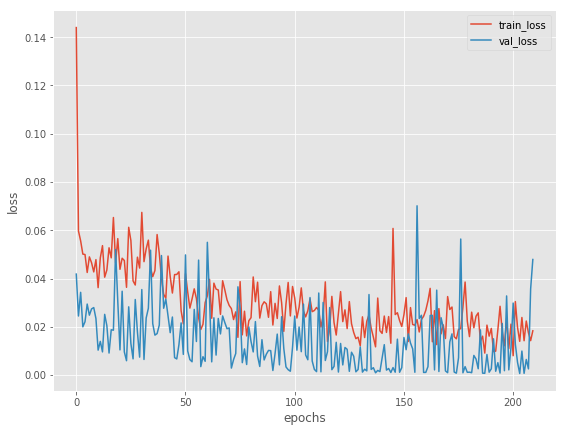

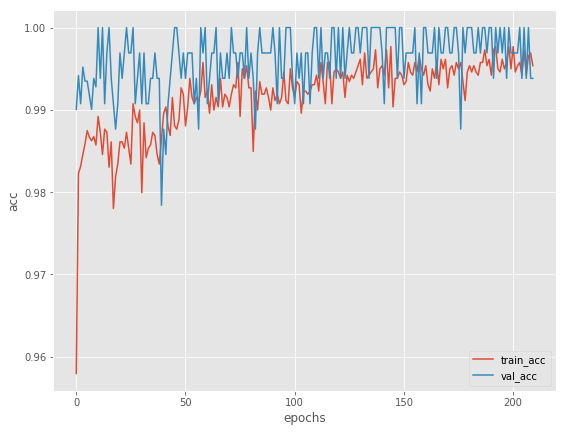

Test average loss / accuracy/ f1_score :  (0.005382443242610543, 0.9979423868312757, 0.9977263936708726)


(<__main__.TrainClassifier at 0x7efd0ca306a0>,
 <list_iterator at 0x7efcac5b5ef0>)

In [96]:
# with open("./cnn/cnn_mb_nets_try1.bin", "wb") as f:
#     pickle.dump(nets, f)

# mod = TrainClassifier(5, model = nets[0], criterion = CrossEntropyLoss(), batch_size = 64)
# test_loss_acc_f1_list1 = [get_avg_la(mod, test_dsa) for i in range(20)]
# print("N0", test_loss_acc_f1_list1)
# mod = TrainClassifier(5, model = nets[4], criterion = CrossEntropyLoss(), batch_size = 64)
# test_loss_acc_f1_list2 = [get_avg_la(mod, test_dsa) for i in range(20)]
# print("N4", test_loss_acc_f1_list2)
# mod = TrainClassifier(5, model = nets[8], criterion = CrossEntropyLoss(), batch_size = 64)
# test_loss_acc_f1_list3 = [get_avg_la(mod, test_dsa) for i in range(20)]
# print("N8", test_loss_acc_f1_list3)

reset_seed(7)
cnn = mixed_net_attn_cnn9(nets, n_outputs = 5)
SAVE_DIR = './cnn/mixed_attn_cnn_9h_try1'
#train_cd_wake_sleep_model
train_cd_wake_sleep_model(5, SAVE_DIR, cnn, 1, train_dsa, val_dsa, test_dsa, ds_list, cd_ws_epochs = 4, batch_size=64)